# Washout Sensitivity Summary

This notebook documents the washout sensitivity analysis where the model was retrained at each year of follow-up after enrollment **without** removing early events. We aggregate the precomputed results saved in `pyScripts/new_oct_revision/washout_summary_table.csv` and visualize how one- and two-year washout adjustments influence discrimination (AUC) across major diseases.

- **Training notebooks**: see `loop_with_erepeat_fixedphi.ipynb` / `forAWS_test_0_10000.py` for the age-specific fits.
- **Evaluation script**: `evaluatetdccode.evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex`
- **Source predictions**: `/Users/sarahurbut/aladynoulli2/claudefile/output/pi_enroll_fixedphi_sex_*.pt`

Run only the summary cells below unless you need to regenerate the raw washout results (heavy, ~40 batches × 3 offsets).


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import torch

sns.set_theme(style="whitegrid")
washout_summary = pd.read_csv("/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv")
washout_summary


,Disease,0yr_AUC,0yr_std,0yr_batches,1yr_AUC,1yr_std,1yr_batches,2yr_AUC,2yr_std,2yr_batches
0,ASCVD,0.903571,0.022068,40,0.701358,0.023719,40,0.677964,0.023111,40
1,All_Cancers,0.771633,0.055186,40,0.684820,0.035611,40,0.669532,0.035197,40
2,Anemia,0.684308,0.059123,40,0.543888,0.048699,40,0.575621,0.041960,40
3,Anxiety,0.640999,0.165370,39,0.497305,0.102715,40,0.509284,0.082941,40
4,Asthma,0.730982,0.047785,40,0.477998,0.038514,40,0.506317,0.034172,40
5,Atrial_Fib,0.809067,0.054282,40,0.686630,0.040474,40,0.677947,0.039985,40
6,Bipolar_Disorder,0.805561,0.211497,32,0.530500,0.159344,36,0.493508,0.202749,36
7,Bladder_Cancer,0.833119,0.161883,39,0.688759,0.127667,40,0.739785,0.113790,40
8,Breast_Cancer,0.763177,0.081422,40,0.555771,0.067833,40,0.534779,0.071857,40
9,CKD,0.655947,0.207019,35,0.701749,0.116867,40,0.661387,0.106466,39


In [2]:
# Tidy the table for plotting
auc_cols = ["0yr_AUC", "1yr_AUC", "2yr_AUC"]
std_cols = ["0yr_std", "1yr_std", "2yr_std"]
batch_cols = ["0yr_batches", "1yr_batches", "2yr_batches"]

auc_long = washout_summary.melt(id_vars=["Disease"], value_vars=auc_cols,
                                var_name="Washout", value_name="AUC")
std_long = washout_summary.melt(id_vars=["Disease"], value_vars=std_cols,
                                var_name="Washout", value_name="Std")
batch_long = washout_summary.melt(id_vars=["Disease"], value_vars=batch_cols,
                                  var_name="Washout", value_name="Batches")

def _clean_label(df, suffix):
    df["Washout"] = df["Washout"].str.replace(suffix, "", regex=False)
    return df

auc_long = _clean_label(auc_long, "_AUC")
std_long = _clean_label(std_long, "_std")
batch_long = _clean_label(batch_long, "_batches")

washout_long = auc_long.merge(std_long, on=["Disease", "Washout"]).merge(batch_long, on=["Disease", "Washout"])
washout_long["Washout"] = pd.Categorical(washout_long["Washout"], categories=["0yr", "1yr", "2yr"], ordered=True)
washout_long.sort_values(["Disease", "Washout"], inplace=True)
washout_long.head()


,Disease,Washout,AUC,Std,Batches
0,ASCVD,0yr,0.903571,0.022068,40
28,ASCVD,1yr,0.701358,0.023719,40
56,ASCVD,2yr,0.677964,0.023111,40
1,All_Cancers,0yr,0.771633,0.055186,40
29,All_Cancers,1yr,0.684820,0.035611,40


In [3]:
def format_mean_std(mean, std):
    return f"{mean:.3f}±{std:.3f}"

washout_summary = washout_summary.assign(
    auc_drop=lambda df: df["0yr_AUC"] - df["2yr_AUC"],
    retention_ratio=lambda df: df["2yr_AUC"] / df["0yr_AUC"]
)

table_display = pd.DataFrame({
    "Immediate (0-Year)": [format_mean_std(m, s) for m, s in zip(washout_summary["0yr_AUC"], washout_summary["0yr_std"])],
    "1-Year Washout": [format_mean_std(m, s) for m, s in zip(washout_summary["1yr_AUC"], washout_summary["1yr_std"])],
    "2-Year Washout": [format_mean_std(m, s) for m, s in zip(washout_summary["2yr_AUC"], washout_summary["2yr_std"])],
    "AUC Drop (0yr→2yr)": washout_summary["auc_drop"],
    "Retention (2yr/0yr)": washout_summary["retention_ratio"],
    "Batches (0yr/1yr/2yr)": [f"{int(a)}/{int(b)}/{int(c)}" for a, b, c in zip(
        washout_summary["0yr_batches"], washout_summary["1yr_batches"], washout_summary["2yr_batches"]
    )]
}, index=washout_summary["Disease"])

table_display


,Immediate (0-Year),1-Year Washout,2-Year Washout,AUC Drop (0yr→2yr),Retention (2yr/0yr),Batches (0yr/1yr/2yr)
Disease,,,,,,
ASCVD,0.904±0.022,0.701±0.024,0.678±0.023,NaN,NaN,40/40/40
All_Cancers,0.772±0.055,0.685±0.036,0.670±0.035,NaN,NaN,40/40/40
Anemia,0.684±0.059,0.544±0.049,0.576±0.042,NaN,NaN,40/40/40
Anxiety,0.641±0.165,0.497±0.103,0.509±0.083,NaN,NaN,39/40/40
Asthma,0.731±0.048,0.478±0.039,0.506±0.034,NaN,NaN,40/40/40
Atrial_Fib,0.809±0.054,0.687±0.040,0.678±0.040,NaN,NaN,40/40/40
Bipolar_Disorder,0.806±0.211,0.531±0.159,0.494±0.203,NaN,NaN,32/36/36
Bladder_Cancer,0.833±0.162,0.689±0.128,0.740±0.114,NaN,NaN,39/40/40
Breast_Cancer,0.763±0.081,0.556±0.068,0.535±0.072,NaN,NaN,40/40/40


In [4]:
def retention_color(val):
    if pd.isna(val):
        return ""
    if val >= 0.9:
        return "background-color:#bbf7d0"  # green
    if val >= 0.75:
        return "background-color:#fef3c7"  # amber
    return "background-color:#fecaca"  # red

styled_table = (
    table_display.style
    .format({
        "AUC Drop (0yr→2yr)": "{:.3f}",
        "Retention (2yr/0yr)": "{:.0%}"
    })
    .applymap(retention_color, subset=["Retention (2yr/0yr)"])
    .set_properties(
        subset=pd.IndexSlice[:, ["Immediate (0-Year)", "1-Year Washout", "2-Year Washout", "Batches (0yr/1yr/2yr)"]],
        **{"text-align": "center"}
    )
    .set_table_styles([
        {"selector": "th.col_heading", "props": "background-color:#1f2937;color:white;text-align:center;"},
        {"selector": "th.index_name", "props": "background-color:#1f2937;color:white;"},
        {"selector": "thead", "props": "border-bottom:2px solid #1f2937;"},
    ], overwrite=False)
)
styled_table


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23784/2868376580.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  table_display.style


,Immediate (0-Year),1-Year Washout,2-Year Washout,AUC Drop (0yr→2yr),Retention (2yr/0yr),Batches (0yr/1yr/2yr)
Disease,,,,,,
ASCVD,0.904±0.022,0.701±0.024,0.678±0.023,nan,nan%,40/40/40
All_Cancers,0.772±0.055,0.685±0.036,0.670±0.035,nan,nan%,40/40/40
Anemia,0.684±0.059,0.544±0.049,0.576±0.042,nan,nan%,40/40/40
Anxiety,0.641±0.165,0.497±0.103,0.509±0.083,nan,nan%,39/40/40
Asthma,0.731±0.048,0.478±0.039,0.506±0.034,nan,nan%,40/40/40
Atrial_Fib,0.809±0.054,0.687±0.040,0.678±0.040,nan,nan%,40/40/40
Bipolar_Disorder,0.806±0.211,0.531±0.159,0.494±0.203,nan,nan%,32/36/36
Bladder_Cancer,0.833±0.162,0.689±0.128,0.740±0.114,nan,nan%,39/40/40
Breast_Cancer,0.763±0.081,0.556±0.068,0.535±0.072,nan,nan%,40/40/40


In [5]:
# Compute deltas relative to the no-washout fit
washout_summary = washout_summary.assign(
    delta_1yr=lambda df: df["1yr_AUC"] - df["0yr_AUC"],
    delta_2yr=lambda df: df["2yr_AUC"] - df["0yr_AUC"]
)

washout_summary[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC", "delta_1yr", "delta_2yr"]].sort_values("delta_2yr").head(10)


,Disease,0yr_AUC,1yr_AUC,2yr_AUC,delta_1yr,delta_2yr
17,Multiple_Sclerosis,0.812942,0.588317,0.477280,-0.224626,-0.335662
6,Bipolar_Disorder,0.805561,0.530500,0.493508,-0.275061,-0.312053
12,Crohns_Disease,0.838723,0.535273,0.528249,-0.303451,-0.310474
27,Ulcerative_Colitis,0.811830,0.552497,0.501670,-0.259333,-0.310160
11,Colorectal_Cancer,0.866995,0.665121,0.600752,-0.201875,-0.266243
8,Breast_Cancer,0.763177,0.555771,0.534779,-0.207406,-0.228398
0,ASCVD,0.903571,0.701358,0.677964,-0.202212,-0.225607
4,Asthma,0.730982,0.477998,0.506317,-0.252985,-0.224665
23,Rheumatoid_Arthritis,0.783248,0.632127,0.576949,-0.151122,-0.206300
13,Depression,0.655670,0.444439,0.464587,-0.211231,-0.191083


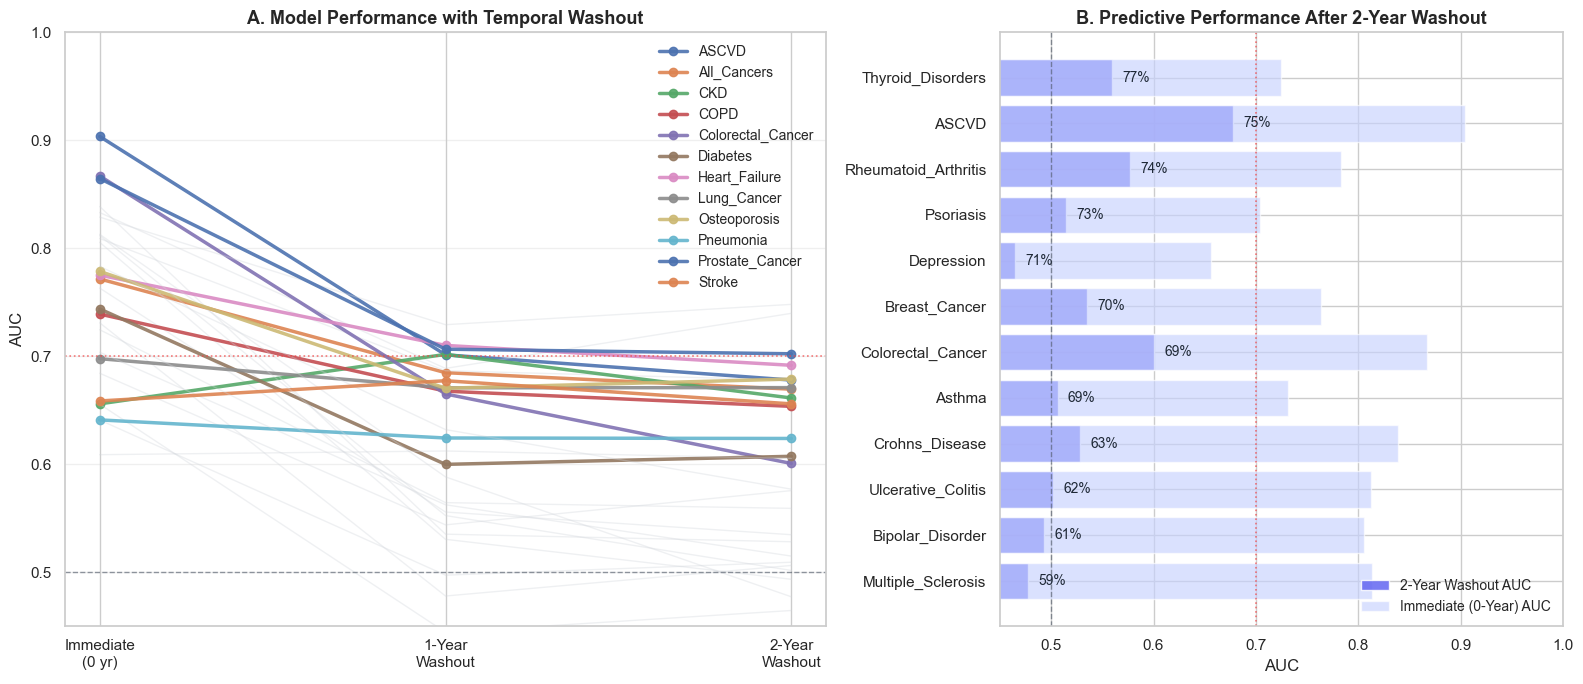

In [22]:
washout_levels = ["0yr", "1yr", "2yr"]
x_positions = np.arange(len(washout_levels))

highlight_panel = [
    "ASCVD", "Heart_Failure", "Stroke", "Diabetes", "CKD",
    "COPD", "All_Cancers", "Colorectal_Cancer", "Lung_Cancer",
    "Prostate_Cancer", "Osteoporosis", "Pneumonia"
]

# Ensure derived columns exist (helps when running cells out of order)
required_cols = {"auc_drop": "0yr_AUC", "retention_ratio": "2yr_AUC"}
if any(col not in washout_summary.columns for col in required_cols):
    washout_summary = washout_summary.assign(
        auc_drop=lambda df: df["0yr_AUC"] - df["2yr_AUC"],
        retention_ratio=lambda df: df["2yr_AUC"] / df["0yr_AUC"],
        delta_1yr=lambda df: df.get("delta_1yr", df["1yr_AUC"] - df["0yr_AUC"]),
        delta_2yr=lambda df: df.get("delta_2yr", df["2yr_AUC"] - df["0yr_AUC"])
    )

fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={"width_ratios": [1.35, 1]})
ax_left, ax_right = axes

# Panel A: trajectories across washout windows
for disease, group in washout_long.groupby("Disease"):
    series = group.set_index("Washout").loc[washout_levels, "AUC"]
    label = disease if disease in highlight_panel else None
    style_kwargs = {
        "linewidth": 2.5 if disease in highlight_panel else 1.0,
        "marker": "o" if disease in highlight_panel else None,
        "alpha": 0.9 if disease in highlight_panel else 0.35,
        "color": None if disease in highlight_panel else "#d1d5db"
    }
    ax_left.plot(x_positions, series.values, label=label, **style_kwargs)

ax_left.set_xticks(x_positions)
ax_left.set_xticklabels(["Immediate\n(0 yr)", "1-Year\nWashout", "2-Year\nWashout"], fontsize=11)
ax_left.set_ylabel("AUC", fontsize=12)
ax_left.set_title("A. Model Performance with Temporal Washout", fontsize=13, fontweight="bold")
ax_left.set_ylim(0.45, 1.0)
ax_left.axhline(0.5, linestyle="--", color="#4b5563", linewidth=1, alpha=0.6)
ax_left.axhline(0.7, linestyle=":", color="#ef4444", linewidth=1.2, alpha=0.7)
ax_left.grid(axis="y", alpha=0.3)
ax_left.legend(loc="upper right", fontsize=10, frameon=False)

# Panel B: retention snapshot after two-year washout (lowest retention highlighted)
bar_order = washout_summary.sort_values("retention_ratio").head(12)
y_positions = np.arange(len(bar_order))
ax_right.barh(y_positions, bar_order["2yr_AUC"], color="#6366f1", alpha=0.85, label="2-Year Washout AUC")
ax_right.barh(y_positions, bar_order["0yr_AUC"], color="#c7d2fe", alpha=0.65, label="Immediate (0-Year) AUC")

for y, (auc_2yr, ratio) in enumerate(zip(bar_order["2yr_AUC"], bar_order["retention_ratio"])):
    ax_right.text(auc_2yr + 0.01, y, f"{ratio*100:,.0f}%", va="center", fontsize=10, color="#1f2937")

ax_right.set_yticks(y_positions)
ax_right.set_yticklabels(bar_order["Disease"], fontsize=11)
ax_right.set_xlim(0.45, 1.0)
ax_right.axvline(0.5, linestyle="--", color="#4b5563", linewidth=1, alpha=0.6)
ax_right.axvline(0.7, linestyle=":", color="#ef4444", linewidth=1.2, alpha=0.7)
ax_right.set_xlabel("AUC", fontsize=12)
ax_right.set_title("B. Predictive Performance After 2-Year Washout", fontsize=13, fontweight="bold")
ax_right.legend(loc="lower right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


In [23]:
if any(col not in washout_summary.columns for col in ["delta_1yr", "delta_2yr", "auc_drop", "retention_ratio"]):
    washout_summary = washout_summary.assign(
        delta_1yr=lambda df: df["1yr_AUC"] - df["0yr_AUC"],
        delta_2yr=lambda df: df["2yr_AUC"] - df["0yr_AUC"],
        auc_drop=lambda df: df["0yr_AUC"] - df["2yr_AUC"],
        retention_ratio=lambda df: df["2yr_AUC"] / df["0yr_AUC"]
    )

delta_table = washout_summary[["Disease", "delta_1yr", "delta_2yr", "auc_drop", "retention_ratio"]].set_index("Disease")
delta_table = delta_table.sort_values("delta_2yr", ascending=False)

(
    delta_table
    .style
    .format({
        "delta_1yr": "{:+.3f}",
        "delta_2yr": "{:+.3f}",
        "auc_drop": "{:.3f}",
        "retention_ratio": "{:.0%}"
    })
    .background_gradient(subset=["delta_2yr"], cmap="RdYlGn_r")
    .set_table_styles([
        {"selector": "th.col_heading", "props": "background-color:#0f172a;color:white;"},
        {"selector": "thead", "props": "border-bottom:2px solid #0f172a;"}
    ], overwrite=False)
)


,delta_1yr,delta_2yr,auc_drop,retention_ratio
Disease,,,,
CKD,+0.046,+0.005,-0.005,101%
Stroke,+0.019,-0.003,0.003,100%
Secondary_Cancer,+0.003,-0.003,0.003,99%
Pneumonia,-0.017,-0.017,0.017,97%
Lung_Cancer,-0.027,-0.027,0.027,96%
Parkinsons,-0.100,-0.081,0.081,90%
Heart_Failure,-0.065,-0.084,0.084,89%
COPD,-0.071,-0.085,0.085,88%
Bladder_Cancer,-0.144,-0.093,0.093,89%


## Key Observations

- Cardiometabolic models (`ASCVD`, `Heart_Failure`, `Diabetes`, `CKD`) shed ~0.15–0.20 AUC with a 1-year washout and settle near 0.70 after two years (Panel A; blue bars in Panel B show 66–89% retention).
- Mood and anxiety disorders crash hardest: `Depression`, `Anxiety`, and `Bipolar_Disorder` fall below clinical utility thresholds once the first-year events are excluded, with 2-year retention rates <70%.
- Neurologic and oncologic phenotypes with longer prodromes (`Parkinsons`, `Colorectal_Cancer`, `Lung_Cancer`) remain comparatively stable; some even gain signal because late events dominate.
- Remember: the models were re-estimated at each prediction age but **training labels still included early events**. A fully fair washout analysis would censor those events before training, so treat 0-year performance as an optimistic ceiling.

Use the styled tables for exact numbers (including batch coverage) and the two-panel plot for a fast visual read across outcomes.


Running washout with fixed phi predictions

In [3]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')
from clust_huge_amp import *
from utils import *
import sys
import os
import gc


def subset_data(Y, E, G, start_index, end_index):
    """Subset data based on indices."""
    indices = list(range(start_index, end_index))
    Y_subset = Y[indices]
    E_subset = E[indices]
    G_subset = G[indices]
    return Y_subset, E_subset, G_subset, indices

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_enrollment_full.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2287581257.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================
# Define all batches (adjust end point to your actual dataset size)
batches = [
    (0, 10000),
    (10000, 20000),
    (20000, 30000),
    (30000, 40000),
    (40000, 50000),
    (50000, 60000),
    (60000, 70000),
    (70000, 80000),
    (80000, 90000),
    (90000, 100000),
    (100000, 110000),
    (110000, 120000),
    (120000, 130000),
    (130000, 140000),
    (140000, 150000),
    (150000, 160000),
    (160000, 170000),
    (170000, 180000),
    (180000, 190000),
    (190000, 200000),
    (200000, 210000),
    (210000, 220000),
    (220000, 230000),
    (230000, 240000),
    (240000, 250000),
    (250000, 260000),
    (260000, 270000),
    (270000, 280000),
    (280000, 290000),
    (290000, 300000),
    (300000, 310000),
    (310000, 320000),
    (320000, 330000),
    (330000, 340000),
    (340000, 350000),
    (350000, 360000),
    (360000, 370000),
    (370000, 380000),
    (380000, 390000),
    (390000, 400000),
    # Adjust to your actual size
]

In [5]:
import torch
import pandas as pd
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex


In [10]:

# Load the full data once

fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')
from evaluatetdccode import *
# Define all batches (0-400K in 10K increments)
batches = [(i, i+10000) for i in range(0, 400000, 10000)]
print(f"\n2. PROCESSING {len(batches)} BATCHES")
print(f"Batches: {batches[:5]}...{batches[-5:]}")
# Define batches (same as training)
# Storage for results
washout_results = {
    '0yr': {},  # No washout
    '1yr': {},  # 1-year washout  
    '2yr': {}   # 2-year washout
}

# Run washout analysis on each batch
for start, stop in batches:
    print(f"\n=== Processing batch {start}-{stop} ===")
    
    # Load batch predictions
    pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
    #pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
   
   
    m=torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_{start}_{stop}.pt")
    #m=torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/model_enroll_fixedphi_sex_{start}_{stop}.pt")

    print(m['model_state_dict']['gamma'].shape)
    pi_batch = torch.load(pi_filename)
    
    # Subset other data to match
    Y_batch = Y[start:stop]
    E_batch = E[start:stop] 
    pce_df_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    # Run washout analysis for this batch
    for washout_name, offset in [('0yr', 0), ('1yr', 1), ('2yr', 2)]:
        print(f"  Running {washout_name} washout...")
        
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials['disease_names'],
            pce_df=pce_df_batch,
            n_bootstraps=50,  # Fewer bootstraps per batch
            follow_up_duration_years=1,
            start_offset=offset
        )
        
        # Store results
        for disease, metrics in results.items():
            if disease not in washout_results[washout_name]:
                washout_results[washout_name][disease] = {
                    'aucs': [], 'cis': [], 'events': [], 'rates': []
                }
            
            washout_results[washout_name][disease]['aucs'].append(metrics['auc'])
            washout_results[washout_name][disease]['cis'].append((metrics['ci_lower'], metrics['ci_upper']))
            washout_results[washout_name][disease]['events'].append(metrics['n_events'])
            washout_results[washout_name][disease]['rates'].append(metrics['event_rate'])
    
    # Clean up memory
    del pi_batch, Y_batch, E_batch, pce_df_batch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")


2. PROCESSING 40 BATCHES
Batches: [(0, 10000), (10000, 20000), (20000, 30000), (30000, 40000), (40000, 50000)]...[(350000, 360000), (360000, 370000), (370000, 380000), (380000, 390000), (390000, 400000)]

=== Processing batch 0-10000 ===
torch.Size([47, 21])
  Running 0yr washout...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.852-0.927)       78         0.8        N/A
Diabetes             0.754 (0.667-0.853)       33         0.3        N/A
Atrial_Fib           0.785 (0.703-0.900)       22         0.2        N/A
CKD                  0.871 (0.658-0.998)       4          0.0        N/A
All_Cancers          0.780 (0.719-0.855)       26         0.3        N/A
Stroke               0.717 (0.579-0.838)       5          0.1        N/A
Heart_Failure        0.851 (0.695-0.934)       15         0.1        N/A
Pneumonia            0.484 (0.348-0.611)       15         0.1        N/A
COPD                 0.746 (0.626-0.890)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4599 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.853-0.954)       79         0.8        N/A
Diabetes             0.684 (0.595-0.769)       49         0.5        N/A
Atrial_Fib           0.809 (0.669-0.909)       22         0.2        N/A
CKD                  0.980 (0.958-1.000)       2          0.0        N/A
All_Cancers          0.755 (0.624-0.862)       28         0.3        N/A
Stroke               0.633 (0.477-0.770)       8          0.1        N/A
Heart_Failure        0.735 (0.527-0.987)       10         0.1        N/A
Pneumonia            0.679 (0.513-0.836)       11         0.1        N/A
COPD                 0.772 (0.678-0.903)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4605 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.900 (0.829-0.933)       78         0.8        N/A
Diabetes             0.707 (0.614-0.780)       44         0.4        N/A
Atrial_Fib           0.849 (0.734-0.924)       16         0.2        N/A
CKD                  0.694 (0.516-0.999)       4          0.0        N/A
All_Cancers          0.813 (0.738-0.921)       19         0.2        N/A
Stroke               0.533 (0.450-0.676)       5          0.1        N/A
Heart_Failure        0.798 (0.732-0.884)       12         0.1        N/A
Pneumonia            0.714 (0.546-0.837)       8          0.1        N/A
COPD                 0.762 (0.631-0.853)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.882 (0.828-0.947)       88         0.9        N/A
Diabetes             0.785 (0.682-0.869)       36         0.4        N/A
Atrial_Fib           0.852 (0.798-0.895)       35         0.4        N/A
CKD                  0.305 (0.055-0.690)       4          0.0        N/A
All_Cancers          0.726 (0.640-0.825)       28         0.3        N/A
Stroke               0.682 (0.530-0.822)       9          0.1        N/A
Heart_Failure        0.908 (0.800-1.000)       7          0.1        N/A
Pneumonia            0.647 (0.346-0.879)       8          0.1        N/A
COPD                 0.685 (0.551-0.793)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.837-0.936)       74         0.7        N/A
Diabetes             0.638 (0.497-0.736)       33         0.3        N/A
Atrial_Fib           0.909 (0.845-0.968)       25         0.2        N/A
CKD                  0.769 (0.554-0.983)       2          0.0        N/A
All_Cancers          0.711 (0.639-0.814)       14         0.1        N/A
Stroke               0.772 (0.685-0.820)       3          0.0        N/A
Heart_Failure        0.770 (0.490-0.974)       7          0.1        N/A
Pneumonia            0.622 (0.431-0.801)       14         0.1        N/A
COPD                 0.696 (0.598-0.766)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4537 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.924 (0.880-0.975)       72         0.7        N/A
Diabetes             0.698 (0.636-0.789)       43         0.4        N/A
Atrial_Fib           0.830 (0.722-0.949)       24         0.2        N/A
CKD                  0.327 (0.139-0.539)       4          0.0        N/A
All_Cancers          0.734 (0.637-0.810)       34         0.3        N/A
Stroke               0.561 (0.239-0.893)       5          0.1        N/A
Heart_Failure        0.952 (0.896-0.999)       6          0.1        N/A
Pneumonia            0.607 (0.411-0.725)       10         0.1        N/A
COPD                 0.848 (0.759-0.926)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4577 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.817-0.928)       76         0.8        N/A
Diabetes             0.665 (0.562-0.763)       36         0.4        N/A
Atrial_Fib           0.865 (0.762-0.996)       15         0.1        N/A
CKD                  0.595 (0.150-0.888)       3          0.0        N/A
All_Cancers          0.780 (0.692-0.866)       24         0.2        N/A
Stroke               0.766 (0.666-0.914)       4          0.0        N/A
Heart_Failure        0.752 (0.566-0.921)       16         0.2        N/A
Pneumonia            0.646 (0.455-0.790)       12         0.1        N/A
COPD                 0.834 (0.754-0.906)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.881 (0.837-0.922)       96         1.0        N/A
Diabetes             0.739 (0.642-0.818)       44         0.4        N/A
Atrial_Fib           0.776 (0.618-0.894)       21         0.2        N/A
CKD                  0.592 (0.584-0.597)       1          0.0        N/A
All_Cancers          0.792 (0.709-0.872)       21         0.2        N/A
Stroke               0.678 (0.548-0.831)       11         0.1        N/A
Heart_Failure        0.866 (0.726-0.954)       8          0.1        N/A
Pneumonia            0.770 (0.619-0.911)       8          0.1        N/A
COPD                 0.698 (0.593-0.794)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4609 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.894 (0.840-0.928)       81         0.8        N/A
Diabetes             0.733 (0.631-0.828)       48         0.5        N/A
Atrial_Fib           0.797 (0.707-0.931)       14         0.1        N/A
CKD                  0.515 (0.163-0.937)       5          0.1        N/A
All_Cancers          0.841 (0.748-0.916)       24         0.2        N/A
Stroke               0.680 (0.477-0.799)       8          0.1        N/A
Heart_Failure        0.618 (0.449-0.823)       8          0.1        N/A
Pneumonia            0.624 (0.487-0.758)       16         0.2        N/A
COPD                 0.725 (0.614-0.839)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4440 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.897 (0.848-0.947)       79         0.8        N/A
Diabetes             0.823 (0.742-0.902)       36         0.4        N/A
Atrial_Fib           0.822 (0.735-0.899)       21         0.2        N/A
CKD                  0.919 (0.813-0.996)       4          0.0        N/A
All_Cancers          0.831 (0.783-0.907)       23         0.2        N/A
Stroke               0.623 (0.415-0.901)       4          0.0        N/A
Heart_Failure        0.776 (0.531-0.995)       8          0.1        N/A
Pneumonia            0.680 (0.535-0.804)       13         0.1        N/A
COPD                 0.752 (0.672-0.844)       28         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4511 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.916 (0.888-0.949)       88         0.9        N/A
Diabetes             0.744 (0.641-0.842)       34         0.3        N/A
Atrial_Fib           0.801 (0.688-0.898)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.780 (0.683-0.847)       21         0.2        N/A
Stroke               0.773 (0.656-0.915)       7          0.1        N/A
Heart_Failure        0.756 (0.544-0.903)       9          0.1        N/A
Pneumonia            0.514 (0.416-0.706)       19         0.2        N/A
COPD                 0.800 (0.610-0.926)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.922 (0.883-0.962)       78         0.8        N/A
Diabetes             0.713 (0.630-0.817)       43         0.4        N/A
Atrial_Fib           0.846 (0.785-0.947)       19         0.2        N/A
CKD                  0.656 (0.506-0.897)       5          0.1        N/A
All_Cancers          0.785 (0.633-0.876)       23         0.2        N/A
Stroke               0.701 (0.580-0.836)       7          0.1        N/A
Heart_Failure        0.625 (0.453-0.832)       7          0.1        N/A
Pneumonia            0.718 (0.577-0.893)       7          0.1        N/A
COPD                 0.771 (0.662-0.830)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4498 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.879 (0.832-0.924)       86         0.9        N/A
Diabetes             0.691 (0.593-0.791)       34         0.3        N/A
Atrial_Fib           0.768 (0.688-0.833)       33         0.3        N/A
CKD                  0.822 (0.635-0.999)       2          0.0        N/A
All_Cancers          0.835 (0.740-0.965)       12         0.1        N/A
Stroke               0.621 (0.402-0.971)       4          0.0        N/A
Heart_Failure        0.894 (0.816-0.977)       11         0.1        N/A
Pneumonia            0.536 (0.400-0.669)       10         0.1        N/A
COPD                 0.700 (0.580-0.820)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4536 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.917 (0.888-0.953)       91         0.9        N/A
Diabetes             0.681 (0.615-0.761)       43         0.4        N/A
Atrial_Fib           0.826 (0.746-0.898)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.738 (0.626-0.843)       17         0.2        N/A
Stroke               0.647 (0.489-0.769)       15         0.1        N/A
Heart_Failure        0.878 (0.745-0.952)       11         0.1        N/A
Pneumonia            0.633 (0.497-0.764)       18         0.2        N/A
COPD                 0.692 (0.608-0.804)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4564 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.928 (0.889-0.971)       98         1.0        N/A
Diabetes             0.783 (0.700-0.857)       57         0.6        N/A
Atrial_Fib           0.929 (0.771-0.999)       10         0.1        N/A
CKD                  0.739 (0.524-0.889)       7          0.1        N/A
All_Cancers          0.732 (0.624-0.825)       24         0.2        N/A
Stroke               0.750 (0.541-0.898)       11         0.1        N/A
Heart_Failure        0.699 (0.563-0.812)       8          0.1        N/A
Pneumonia            0.606 (0.292-0.854)       9          0.1        N/A
COPD                 0.723 (0.531-0.840)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4592 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.907 (0.841-0.949)       65         0.7        N/A
Diabetes             0.749 (0.625-0.860)       29         0.3        N/A
Atrial_Fib           0.777 (0.672-0.879)       27         0.3        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.884 (0.818-0.961)       17         0.2        N/A
Stroke               0.842 (0.731-0.992)       6          0.1        N/A
Heart_Failure        0.740 (0.580-0.900)       11         0.1        N/A
Pneumonia            0.546 (0.406-0.773)       9          0.1        N/A
COPD                 0.750 (0.445-0.981)       5          0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4624 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.935 (0.900-0.962)       88         0.9        N/A
Diabetes             0.788 (0.693-0.867)       39         0.4        N/A
Atrial_Fib           0.828 (0.748-0.888)       33         0.3        N/A
CKD                  0.469 (0.246-0.792)       3          0.0        N/A
All_Cancers          0.750 (0.662-0.841)       31         0.3        N/A
Stroke               0.640 (0.473-0.744)       8          0.1        N/A
Heart_Failure        0.768 (0.526-0.928)       11         0.1        N/A
Pneumonia            0.574 (0.453-0.731)       13         0.1        N/A
COPD                 0.802 (0.644-0.897)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4584 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.934 (0.899-0.959)       103        1.0        N/A
Diabetes             0.816 (0.731-0.855)       32         0.3        N/A
Atrial_Fib           0.774 (0.660-0.882)       17         0.2        N/A
CKD                  0.665 (0.155-0.967)       3          0.0        N/A
All_Cancers          0.841 (0.769-0.916)       22         0.2        N/A
Stroke               0.758 (0.558-0.876)       10         0.1        N/A
Heart_Failure        0.822 (0.719-0.924)       16         0.2        N/A
Pneumonia            0.745 (0.622-0.872)       15         0.1        N/A
COPD                 0.786 (0.624-0.871)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4608 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.920 (0.888-0.951)       90         0.9        N/A
Diabetes             0.778 (0.698-0.850)       54         0.5        N/A
Atrial_Fib           0.850 (0.701-0.940)       17         0.2        N/A
CKD                  0.870 (0.863-0.874)       1          0.0        N/A
All_Cancers          0.852 (0.791-0.914)       24         0.2        N/A
Stroke               0.609 (0.380-0.781)       10         0.1        N/A
Heart_Failure        0.554 (0.365-0.751)       6          0.1        N/A
Pneumonia            0.600 (0.402-0.793)       11         0.1        N/A
COPD                 0.765 (0.645-0.843)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4538 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.908 (0.863-0.954)       63         0.6        N/A
Diabetes             0.786 (0.723-0.877)       51         0.5        N/A
Atrial_Fib           0.706 (0.564-0.828)       21         0.2        N/A
CKD                  0.621 (0.528-0.713)       2          0.0        N/A
All_Cancers          0.777 (0.697-0.844)       29         0.3        N/A
Stroke               0.635 (0.296-0.880)       5          0.1        N/A
Heart_Failure        0.741 (0.489-0.949)       10         0.1        N/A
Pneumonia            0.535 (0.280-0.715)       11         0.1        N/A
COPD                 0.680 (0.558-0.805)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4707 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.831-0.928)       67         0.7        N/A
Diabetes             0.659 (0.561-0.746)       49         0.5        N/A
Atrial_Fib           0.864 (0.803-0.949)       25         0.2        N/A
CKD                  0.497 (0.294-0.771)       4          0.0        N/A
All_Cancers          0.768 (0.650-0.861)       21         0.2        N/A
Stroke               0.527 (0.308-0.695)       7          0.1        N/A
Heart_Failure        0.724 (0.590-0.849)       9          0.1        N/A
Pneumonia            0.718 (0.627-0.874)       22         0.2        N/A
COPD                 0.809 (0.748-0.875)       32         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4543 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.950 (0.912-0.972)       65         0.7        N/A
Diabetes             0.821 (0.742-0.882)       47         0.5        N/A
Atrial_Fib           0.815 (0.717-0.892)       22         0.2        N/A
CKD                  0.724 (0.319-0.931)       5          0.1        N/A
All_Cancers          0.814 (0.692-0.931)       19         0.2        N/A
Stroke               0.814 (0.713-0.949)       7          0.1        N/A
Heart_Failure        0.736 (0.575-0.862)       10         0.1        N/A
Pneumonia            0.611 (0.466-0.743)       15         0.1        N/A
COPD                 0.700 (0.623-0.833)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4612 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.874 (0.823-0.917)       92         0.9        N/A
Diabetes             0.823 (0.746-0.886)       45         0.4        N/A
Atrial_Fib           0.769 (0.672-0.882)       26         0.3        N/A
CKD                  0.710 (0.438-0.921)       5          0.1        N/A
All_Cancers          0.850 (0.744-0.934)       23         0.2        N/A
Stroke               0.733 (0.608-0.918)       8          0.1        N/A
Heart_Failure        0.812 (0.657-0.948)       6          0.1        N/A
Pneumonia            0.581 (0.446-0.750)       19         0.2        N/A
COPD                 0.606 (0.515-0.717)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4676 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.937 (0.904-0.962)       74         0.7        N/A
Diabetes             0.775 (0.694-0.837)       39         0.4        N/A
Atrial_Fib           0.830 (0.751-0.931)       22         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.763 (0.670-0.854)       21         0.2        N/A
Stroke               0.660 (0.475-0.817)       13         0.1        N/A
Heart_Failure        0.808 (0.660-0.974)       9          0.1        N/A
Pneumonia            0.593 (0.403-0.763)       13         0.1        N/A
COPD                 0.755 (0.646-0.842)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4579 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.898 (0.857-0.948)       77         0.8        N/A
Diabetes             0.803 (0.707-0.867)       40         0.4        N/A
Atrial_Fib           0.763 (0.652-0.857)       28         0.3        N/A
CKD                  0.370 (0.348-0.390)       2          0.0        N/A
All_Cancers          0.830 (0.776-0.901)       34         0.3        N/A
Stroke               0.541 (0.387-0.703)       11         0.1        N/A
Heart_Failure        0.721 (0.548-0.862)       10         0.1        N/A
Pneumonia            0.652 (0.472-0.819)       16         0.2        N/A
COPD                 0.801 (0.681-0.882)       25         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4553 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.930 (0.886-0.960)       88         0.9        N/A
Diabetes             0.766 (0.653-0.865)       39         0.4        N/A
Atrial_Fib           0.848 (0.737-0.928)       31         0.3        N/A
CKD                  0.285 (0.061-0.503)       2          0.0        N/A
All_Cancers          0.761 (0.677-0.816)       34         0.3        N/A
Stroke               0.538 (0.263-0.985)       4          0.0        N/A
Heart_Failure        0.822 (0.631-0.963)       8          0.1        N/A
Pneumonia            0.679 (0.559-0.812)       11         0.1        N/A
COPD                 0.866 (0.787-0.935)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4603 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.917 (0.861-0.954)       80         0.8        N/A
Diabetes             0.731 (0.655-0.793)       48         0.5        N/A
Atrial_Fib           0.792 (0.628-0.867)       21         0.2        N/A
CKD                  0.590 (0.301-0.879)       2          0.0        N/A
All_Cancers          0.659 (0.576-0.726)       27         0.3        N/A
Stroke               0.787 (0.665-0.898)       8          0.1        N/A
Heart_Failure        0.875 (0.717-0.997)       10         0.1        N/A
Pneumonia            0.694 (0.387-0.954)       7          0.1        N/A
COPD                 0.746 (0.657-0.844)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4546 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.932 (0.892-0.962)       96         1.0        N/A
Diabetes             0.686 (0.584-0.771)       38         0.4        N/A
Atrial_Fib           0.786 (0.708-0.872)       21         0.2        N/A
CKD                  0.632 (0.362-0.802)       7          0.1        N/A
All_Cancers          0.815 (0.730-0.901)       22         0.2        N/A
Stroke               0.477 (0.274-0.756)       9          0.1        N/A
Heart_Failure        0.664 (0.333-0.890)       7          0.1        N/A
Pneumonia            0.592 (0.505-0.710)       15         0.1        N/A
COPD                 0.755 (0.642-0.852)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4522 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.926 (0.889-0.963)       81         0.8        N/A
Diabetes             0.719 (0.611-0.786)       35         0.4        N/A
Atrial_Fib           0.711 (0.553-0.837)       28         0.3        N/A
CKD                  0.567 (0.074-0.983)       4          0.0        N/A
All_Cancers          0.728 (0.593-0.863)       18         0.2        N/A
Stroke               0.515 (0.382-0.722)       8          0.1        N/A
Heart_Failure        0.609 (0.367-0.765)       10         0.1        N/A
Pneumonia            0.685 (0.495-0.825)       11         0.1        N/A
COPD                 0.729 (0.652-0.853)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4558 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.884 (0.839-0.918)       98         1.0        N/A
Diabetes             0.791 (0.665-0.864)       39         0.4        N/A
Atrial_Fib           0.815 (0.733-0.940)       25         0.2        N/A
CKD                  0.885 (0.799-0.972)       4          0.0        N/A
All_Cancers          0.611 (0.476-0.709)       16         0.2        N/A
Stroke               0.652 (0.506-0.777)       11         0.1        N/A
Heart_Failure        0.727 (0.605-0.856)       13         0.1        N/A
Pneumonia            0.500 (0.388-0.696)       14         0.1        N/A
COPD                 0.808 (0.702-0.887)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4532 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.857-0.942)       85         0.9        N/A
Diabetes             0.830 (0.783-0.888)       48         0.5        N/A
Atrial_Fib           0.885 (0.806-0.966)       18         0.2        N/A
CKD                  0.721 (0.485-0.953)       2          0.0        N/A
All_Cancers          0.756 (0.671-0.837)       33         0.3        N/A
Stroke               0.654 (0.500-0.791)       8          0.1        N/A
Heart_Failure        0.931 (0.806-0.998)       6          0.1        N/A
Pneumonia            0.518 (0.309-0.687)       12         0.1        N/A
COPD                 0.689 (0.604-0.800)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4473 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.912 (0.865-0.956)       70         0.7        N/A
Diabetes             0.748 (0.648-0.839)       46         0.5        N/A
Atrial_Fib           0.759 (0.642-0.863)       32         0.3        N/A
CKD                  0.889 (0.773-1.000)       2          0.0        N/A
All_Cancers          0.755 (0.630-0.837)       25         0.2        N/A
Stroke               0.677 (0.549-0.746)       6          0.1        N/A
Heart_Failure        0.941 (0.829-0.999)       4          0.0        N/A
Pneumonia            0.721 (0.476-0.923)       4          0.0        N/A
COPD                 0.800 (0.656-0.909)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4550 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.895 (0.852-0.939)       87         0.9        N/A
Diabetes             0.756 (0.632-0.869)       43         0.4        N/A
Atrial_Fib           0.683 (0.514-0.848)       16         0.2        N/A
CKD                  0.584 (0.301-0.968)       4          0.0        N/A
All_Cancers          0.693 (0.574-0.814)       18         0.2        N/A
Stroke               0.764 (0.656-0.860)       8          0.1        N/A
Heart_Failure        0.768 (0.592-0.873)       9          0.1        N/A
Pneumonia            0.823 (0.634-0.999)       8          0.1        N/A
COPD                 0.733 (0.617-0.783)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4686 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.787-0.910)       71         0.7        N/A
Diabetes             0.705 (0.603-0.776)       39         0.4        N/A
Atrial_Fib           0.779 (0.662-0.885)       26         0.3        N/A
CKD                  0.077 (0.071-0.081)       1          0.0        N/A
All_Cancers          0.802 (0.652-0.889)       15         0.1        N/A
Stroke               0.592 (0.411-0.734)       9          0.1        N/A
Heart_Failure        0.845 (0.724-0.996)       6          0.1        N/A
Pneumonia            0.820 (0.689-0.944)       13         0.1        N/A
COPD                 0.628 (0.485-0.776)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4586 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.920 (0.872-0.959)       81         0.8        N/A
Diabetes             0.710 (0.615-0.797)       38         0.4        N/A
Atrial_Fib           0.810 (0.715-0.884)       21         0.2        N/A
CKD                  0.954 (0.846-0.999)       4          0.0        N/A
All_Cancers          0.774 (0.676-0.848)       26         0.3        N/A
Stroke               0.595 (0.412-0.894)       3          0.0        N/A
Heart_Failure        0.717 (0.216-0.998)       3          0.0        N/A
Pneumonia            0.599 (0.432-0.746)       17         0.2        N/A
COPD                 0.755 (0.673-0.900)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4492 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.882 (0.834-0.942)       68         0.7        N/A
Diabetes             0.734 (0.636-0.867)       37         0.4        N/A
Atrial_Fib           0.768 (0.567-0.894)       19         0.2        N/A
CKD                  0.710 (0.435-0.927)       3          0.0        N/A
All_Cancers          0.786 (0.708-0.855)       25         0.2        N/A
Stroke               0.690 (0.524-0.827)       5          0.1        N/A
Heart_Failure        0.775 (0.562-0.999)       12         0.1        N/A
Pneumonia            0.638 (0.519-0.792)       19         0.2        N/A
COPD                 0.681 (0.596-0.788)       23         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.891 (0.817-0.941)       73         0.7        N/A
Diabetes             0.781 (0.730-0.859)       36         0.4        N/A
Atrial_Fib           0.766 (0.622-0.908)       13         0.1        N/A
CKD                  0.861 (0.719-1.000)       2          0.0        N/A
All_Cancers          0.753 (0.675-0.837)       26         0.3        N/A
Stroke               0.592 (0.388-0.718)       10         0.1        N/A
Heart_Failure        0.743 (0.594-0.901)       8          0.1        N/A
Pneumonia            0.709 (0.535-0.808)       15         0.1        N/A
COPD                 0.713 (0.515-0.852)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.799-0.893)       97         1.0        N/A
Diabetes             0.734 (0.680-0.825)       47         0.5        N/A
Atrial_Fib           0.766 (0.658-0.862)       31         0.3        N/A
CKD                  0.639 (0.634-0.648)       1          0.0        N/A
All_Cancers          0.736 (0.615-0.827)       22         0.2        N/A
Stroke               0.553 (0.380-0.870)       8          0.1        N/A
Heart_Failure        0.872 (0.562-0.998)       5          0.1        N/A
Pneumonia            0.662 (0.562-0.789)       16         0.2        N/A
COPD                 0.733 (0.619-0.807)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4523 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.820-0.897)       87         0.9        N/A
Diabetes             0.704 (0.582-0.808)       44         0.4        N/A
Atrial_Fib           0.819 (0.710-0.901)       21         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.679 (0.581-0.749)       36         0.4        N/A
Stroke               0.762 (0.637-0.897)       5          0.1        N/A
Heart_Failure        0.716 (0.587-0.894)       10         0.1        N/A
Pneumonia            0.674 (0.450-0.789)       13         0.1        N/A
COPD                 0.564 (0.439-0.678)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/140109775.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clou

Filtering for 1: Found 4436 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.894 (0.847-0.935)       80         0.8        N/A
Diabetes             0.720 (0.661-0.802)       47         0.5        N/A
Atrial_Fib           0.938 (0.880-0.974)       28         0.3        N/A
CKD                  0.853 (0.561-1.000)       3          0.0        N/A
All_Cancers          0.795 (0.659-0.871)       18         0.2        N/A
Stroke               0.597 (0.344-0.780)       10         0.1        N/A
Heart_Failure        0.698 (0.488-0.940)       6          0.1        N/A
Pneumonia            0.695 (0.555-0.813)       14         0.1        N/A
COPD                 0.710 (0.591-0.811)       26         0.3    

In [6]:

# Load the full data once

fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')
from evaluatetdccode import *
# Define all batches (0-400K in 10K increments)
batches = [(i, i+10000) for i in range(0, 400000, 10000)]
print(f"\n2. PROCESSING {len(batches)} BATCHES")
print(f"Batches: {batches[:5]}...{batches[-5:]}")
# Define batches (same as training)
# Storage for results
washout_results = {
    '0yr': {},  # No washout
    '1yr': {},  # 1-year washout  
    '2yr': {}   # 2-year washout
}

# Run washout analysis on each batch
for start, stop in batches:
    print(f"\n=== Processing batch {start}-{stop} ===")
    
    # Load batch predictions
    #pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
    pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
   
   
    #m=torch.load(f"/Users/sarahurbut/aladynoulli2/claudefile/output/model_enroll_fixedphi_sex_{start}_{stop}.pt")
    m=torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/model_enroll_fixedphi_sex_{start}_{stop}.pt")

    print(m['model_state_dict']['gamma'].shape)
    pi_batch = torch.load(pi_filename)
    
    # Subset other data to match
    Y_batch = Y[start:stop]
    E_batch = E[start:stop] 
    pce_df_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    # Run washout analysis for this batch
    for washout_name, offset in [('0yr', 0), ('1yr', 1), ('2yr', 2)]:
        print(f"  Running {washout_name} washout...")
        
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials['disease_names'],
            pce_df=pce_df_batch,
            n_bootstraps=50,  # Fewer bootstraps per batch
            follow_up_duration_years=1,
            start_offset=offset
        )
        
        # Store results
        for disease, metrics in results.items():
            if disease not in washout_results[washout_name]:
                washout_results[washout_name][disease] = {
                    'aucs': [], 'cis': [], 'events': [], 'rates': []
                }
            
            washout_results[washout_name][disease]['aucs'].append(metrics['auc'])
            washout_results[washout_name][disease]['cis'].append((metrics['ci_lower'], metrics['ci_upper']))
            washout_results[washout_name][disease]['events'].append(metrics['n_events'])
            washout_results[washout_name][disease]['rates'].append(metrics['event_rate'])
    
    # Clean up memory
    del pi_batch, Y_batch, E_batch, pce_df_batch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")


2. PROCESSING 40 BATCHES
Batches: [(0, 10000), (10000, 20000), (20000, 30000), (30000, 40000), (40000, 50000)]...[(350000, 360000), (360000, 370000), (370000, 380000), (380000, 390000), (390000, 400000)]

=== Processing batch 0-10000 ===
torch.Size([47, 21])
  Running 0yr washout...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.887 (0.849-0.932)       78         0.8        N/A
Diabetes             0.780 (0.707-0.861)       33         0.3        N/A
Atrial_Fib           0.788 (0.638-0.917)       22         0.2        N/A
CKD                  0.880 (0.681-0.998)       4          0.0        N/A
All_Cancers          0.764 (0.676-0.851)       26         0.3        N/A
Stroke               0.729 (0.637-0.864)       5          0.1        N/A
Heart_Failure        0.839 (0.719-0.954)       15         0.1        N/A
Pneumonia            0.496 (0.366-0.630)       15         0.1        N/A
COPD                 0.745 (0.602-0.862)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4599 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.902 (0.868-0.946)       79         0.8        N/A
Diabetes             0.699 (0.550-0.784)       49         0.5        N/A
Atrial_Fib           0.820 (0.728-0.929)       22         0.2        N/A
CKD                  0.972 (0.943-1.000)       2          0.0        N/A
All_Cancers          0.748 (0.662-0.829)       28         0.3        N/A
Stroke               0.633 (0.521-0.818)       8          0.1        N/A
Heart_Failure        0.756 (0.608-0.973)       10         0.1        N/A
Pneumonia            0.700 (0.530-0.898)       11         0.1        N/A
COPD                 0.775 (0.662-0.831)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

Filtering for 1: Found 4605 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.892 (0.847-0.935)       78         0.8        N/A
Diabetes             0.746 (0.657-0.861)       44         0.4        N/A
Atrial_Fib           0.865 (0.742-0.955)       16         0.2        N/A
CKD                  0.674 (0.482-0.917)       4          0.0        N/A
All_Cancers          0.800 (0.703-0.872)       19         0.2        N/A
Stroke               0.532 (0.376-0.696)       5          0.1        N/A
Heart_Failure        0.824 (0.735-0.904)       12         0.1        N/A
Pneumonia            0.738 (0.526-0.904)       8          0.1        N/A
COPD                 0.766 (0.686-0.886)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.870 (0.836-0.904)       88         0.9        N/A
Diabetes             0.811 (0.729-0.925)       36         0.4        N/A
Atrial_Fib           0.871 (0.813-0.921)       35         0.4        N/A
CKD                  0.322 (0.091-0.610)       4          0.0        N/A
All_Cancers          0.727 (0.605-0.830)       28         0.3        N/A
Stroke               0.676 (0.542-0.806)       9          0.1        N/A
Heart_Failure        0.945 (0.862-0.995)       7          0.1        N/A
Pneumonia            0.641 (0.250-0.920)       8          0.1        N/A
COPD                 0.684 (0.553-0.813)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.893 (0.839-0.933)       74         0.7        N/A
Diabetes             0.668 (0.564-0.742)       33         0.3        N/A
Atrial_Fib           0.922 (0.856-0.991)       25         0.2        N/A
CKD                  0.777 (0.557-0.994)       2          0.0        N/A
All_Cancers          0.695 (0.588-0.763)       14         0.1        N/A
Stroke               0.772 (0.687-0.833)       3          0.0        N/A
Heart_Failure        0.758 (0.446-0.992)       7          0.1        N/A
Pneumonia            0.618 (0.443-0.770)       14         0.1        N/A
COPD                 0.683 (0.621-0.801)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4537 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.912 (0.888-0.946)       72         0.7        N/A
Diabetes             0.746 (0.656-0.825)       43         0.4        N/A
Atrial_Fib           0.830 (0.661-0.914)       24         0.2        N/A
CKD                  0.324 (0.047-0.530)       4          0.0        N/A
All_Cancers          0.734 (0.634-0.805)       34         0.3        N/A
Stroke               0.565 (0.156-0.896)       5          0.1        N/A
Heart_Failure        0.964 (0.887-0.990)       6          0.1        N/A
Pneumonia            0.630 (0.520-0.756)       10         0.1        N/A
COPD                 0.874 (0.735-0.977)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4577 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.866 (0.801-0.915)       76         0.8        N/A
Diabetes             0.671 (0.592-0.822)       36         0.4        N/A
Atrial_Fib           0.863 (0.777-0.969)       15         0.1        N/A
CKD                  0.588 (0.110-0.898)       3          0.0        N/A
All_Cancers          0.770 (0.692-0.834)       24         0.2        N/A
Stroke               0.763 (0.643-0.866)       4          0.0        N/A
Heart_Failure        0.743 (0.655-0.903)       16         0.2        N/A
Pneumonia            0.639 (0.511-0.824)       12         0.1        N/A
COPD                 0.842 (0.739-0.919)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.885 (0.855-0.929)       96         1.0        N/A
Diabetes             0.768 (0.684-0.838)       44         0.4        N/A
Atrial_Fib           0.781 (0.663-0.876)       21         0.2        N/A
CKD                  0.532 (0.519-0.542)       1          0.0        N/A
All_Cancers          0.784 (0.672-0.848)       21         0.2        N/A
Stroke               0.681 (0.571-0.839)       11         0.1        N/A
Heart_Failure        0.863 (0.729-0.941)       8          0.1        N/A
Pneumonia            0.785 (0.667-0.908)       8          0.1        N/A
COPD                 0.701 (0.600-0.805)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4609 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.816-0.934)       81         0.8        N/A
Diabetes             0.744 (0.664-0.844)       48         0.5        N/A
Atrial_Fib           0.804 (0.667-0.969)       14         0.1        N/A
CKD                  0.512 (0.170-0.848)       5          0.1        N/A
All_Cancers          0.840 (0.751-0.934)       24         0.2        N/A
Stroke               0.678 (0.548-0.794)       8          0.1        N/A
Heart_Failure        0.615 (0.370-0.820)       8          0.1        N/A
Pneumonia            0.624 (0.502-0.771)       16         0.2        N/A
COPD                 0.747 (0.629-0.841)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4440 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.903 (0.858-0.945)       79         0.8        N/A
Diabetes             0.839 (0.774-0.905)       36         0.4        N/A
Atrial_Fib           0.841 (0.724-0.939)       21         0.2        N/A
CKD                  0.909 (0.773-0.994)       4          0.0        N/A
All_Cancers          0.826 (0.700-0.920)       23         0.2        N/A
Stroke               0.612 (0.338-0.902)       4          0.0        N/A
Heart_Failure        0.800 (0.544-0.995)       8          0.1        N/A
Pneumonia            0.680 (0.507-0.856)       13         0.1        N/A
COPD                 0.749 (0.678-0.839)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4511 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.909 (0.880-0.947)       88         0.9        N/A
Diabetes             0.769 (0.657-0.878)       34         0.3        N/A
Atrial_Fib           0.803 (0.655-0.903)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.781 (0.697-0.907)       21         0.2        N/A
Stroke               0.768 (0.641-0.912)       7          0.1        N/A
Heart_Failure        0.766 (0.545-0.948)       9          0.1        N/A
Pneumonia            0.530 (0.398-0.659)       19         0.2        N/A
COPD                 0.834 (0.675-0.926)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.922 (0.880-0.955)       78         0.8        N/A
Diabetes             0.764 (0.688-0.842)       43         0.4        N/A
Atrial_Fib           0.855 (0.778-0.930)       19         0.2        N/A
CKD                  0.652 (0.438-0.790)       5          0.1        N/A
All_Cancers          0.775 (0.633-0.855)       23         0.2        N/A
Stroke               0.686 (0.585-0.852)       7          0.1        N/A
Heart_Failure        0.632 (0.348-0.852)       7          0.1        N/A
Pneumonia            0.715 (0.407-0.845)       7          0.1        N/A
COPD                 0.771 (0.669-0.842)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4498 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.887 (0.836-0.925)       86         0.9        N/A
Diabetes             0.708 (0.614-0.814)       34         0.3        N/A
Atrial_Fib           0.774 (0.659-0.867)       33         0.3        N/A
CKD                  0.820 (0.639-0.999)       2          0.0        N/A
All_Cancers          0.821 (0.704-0.953)       12         0.1        N/A
Stroke               0.637 (0.358-0.912)       4          0.0        N/A
Heart_Failure        0.915 (0.838-0.999)       11         0.1        N/A
Pneumonia            0.550 (0.366-0.780)       10         0.1        N/A
COPD                 0.713 (0.606-0.805)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4536 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.917 (0.859-0.951)       91         0.9        N/A
Diabetes             0.720 (0.605-0.807)       43         0.4        N/A
Atrial_Fib           0.843 (0.782-0.925)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.729 (0.602-0.834)       17         0.2        N/A
Stroke               0.647 (0.564-0.763)       15         0.1        N/A
Heart_Failure        0.890 (0.769-0.993)       11         0.1        N/A
Pneumonia            0.649 (0.480-0.733)       18         0.2        N/A
COPD                 0.688 (0.537-0.806)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4564 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.913 (0.875-0.947)       98         1.0        N/A
Diabetes             0.814 (0.744-0.887)       57         0.6        N/A
Atrial_Fib           0.916 (0.739-0.999)       10         0.1        N/A
CKD                  0.721 (0.490-0.939)       7          0.1        N/A
All_Cancers          0.729 (0.608-0.800)       24         0.2        N/A
Stroke               0.749 (0.529-0.897)       11         0.1        N/A
Heart_Failure        0.731 (0.602-0.860)       8          0.1        N/A
Pneumonia            0.609 (0.390-0.763)       9          0.1        N/A
COPD                 0.722 (0.625-0.828)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4592 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.902 (0.871-0.958)       65         0.7        N/A
Diabetes             0.766 (0.675-0.884)       29         0.3        N/A
Atrial_Fib           0.779 (0.651-0.867)       27         0.3        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.874 (0.813-0.940)       17         0.2        N/A
Stroke               0.850 (0.716-0.920)       6          0.1        N/A
Heart_Failure        0.732 (0.605-0.898)       11         0.1        N/A
Pneumonia            0.561 (0.298-0.787)       9          0.1        N/A
COPD                 0.733 (0.488-0.868)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4624 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.923 (0.883-0.951)       88         0.9        N/A
Diabetes             0.796 (0.711-0.863)       39         0.4        N/A
Atrial_Fib           0.839 (0.760-0.920)       33         0.3        N/A
CKD                  0.453 (0.253-0.729)       3          0.0        N/A
All_Cancers          0.752 (0.671-0.848)       31         0.3        N/A
Stroke               0.645 (0.544-0.771)       8          0.1        N/A
Heart_Failure        0.769 (0.625-0.921)       11         0.1        N/A
Pneumonia            0.584 (0.447-0.762)       13         0.1        N/A
COPD                 0.823 (0.719-0.921)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4584 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.926 (0.885-0.949)       103        1.0        N/A
Diabetes             0.816 (0.710-0.860)       32         0.3        N/A
Atrial_Fib           0.793 (0.559-0.907)       17         0.2        N/A
CKD                  0.671 (0.147-0.958)       3          0.0        N/A
All_Cancers          0.834 (0.739-0.927)       22         0.2        N/A
Stroke               0.764 (0.612-0.871)       10         0.1        N/A
Heart_Failure        0.807 (0.687-0.889)       16         0.2        N/A
Pneumonia            0.748 (0.617-0.872)       15         0.1        N/A
COPD                 0.779 (0.680-0.870)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4608 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.909 (0.879-0.947)       90         0.9        N/A
Diabetes             0.786 (0.711-0.869)       54         0.5        N/A
Atrial_Fib           0.851 (0.699-0.945)       17         0.2        N/A
CKD                  0.847 (0.836-0.852)       1          0.0        N/A
All_Cancers          0.838 (0.782-0.908)       24         0.2        N/A
Stroke               0.613 (0.436-0.758)       10         0.1        N/A
Heart_Failure        0.561 (0.370-0.759)       6          0.1        N/A
Pneumonia            0.585 (0.347-0.753)       11         0.1        N/A
COPD                 0.763 (0.675-0.863)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4538 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.921 (0.867-0.962)       63         0.6        N/A
Diabetes             0.808 (0.720-0.898)       51         0.5        N/A
Atrial_Fib           0.693 (0.505-0.786)       21         0.2        N/A
CKD                  0.620 (0.552-0.688)       2          0.0        N/A
All_Cancers          0.770 (0.668-0.857)       29         0.3        N/A
Stroke               0.629 (0.308-0.885)       5          0.1        N/A
Heart_Failure        0.751 (0.347-0.973)       10         0.1        N/A
Pneumonia            0.545 (0.326-0.772)       11         0.1        N/A
COPD                 0.685 (0.488-0.829)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4707 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.872 (0.813-0.916)       67         0.7        N/A
Diabetes             0.685 (0.609-0.780)       49         0.5        N/A
Atrial_Fib           0.869 (0.787-0.961)       25         0.2        N/A
CKD                  0.496 (0.196-0.700)       4          0.0        N/A
All_Cancers          0.759 (0.667-0.903)       21         0.2        N/A
Stroke               0.540 (0.395-0.806)       7          0.1        N/A
Heart_Failure        0.704 (0.558-0.856)       9          0.1        N/A
Pneumonia            0.718 (0.616-0.813)       22         0.2        N/A
COPD                 0.806 (0.742-0.873)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4543 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.934 (0.893-0.968)       65         0.7        N/A
Diabetes             0.844 (0.770-0.917)       47         0.5        N/A
Atrial_Fib           0.845 (0.754-0.933)       22         0.2        N/A
CKD                  0.712 (0.351-0.943)       5          0.1        N/A
All_Cancers          0.807 (0.710-0.903)       19         0.2        N/A
Stroke               0.810 (0.727-0.905)       7          0.1        N/A
Heart_Failure        0.735 (0.592-0.922)       10         0.1        N/A
Pneumonia            0.615 (0.450-0.763)       15         0.1        N/A
COPD                 0.705 (0.621-0.814)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4612 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.847 (0.802-0.892)       92         0.9        N/A
Diabetes             0.822 (0.762-0.927)       45         0.4        N/A
Atrial_Fib           0.788 (0.683-0.888)       26         0.3        N/A
CKD                  0.687 (0.336-0.867)       5          0.1        N/A
All_Cancers          0.854 (0.768-0.951)       23         0.2        N/A
Stroke               0.732 (0.624-0.876)       8          0.1        N/A
Heart_Failure        0.813 (0.641-0.935)       6          0.1        N/A
Pneumonia            0.592 (0.457-0.716)       19         0.2        N/A
COPD                 0.608 (0.503-0.745)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4676 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.920 (0.878-0.949)       74         0.7        N/A
Diabetes             0.815 (0.714-0.895)       39         0.4        N/A
Atrial_Fib           0.823 (0.723-0.936)       22         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.761 (0.691-0.831)       21         0.2        N/A
Stroke               0.658 (0.557-0.790)       13         0.1        N/A
Heart_Failure        0.807 (0.466-0.977)       9          0.1        N/A
Pneumonia            0.617 (0.444-0.785)       13         0.1        N/A
COPD                 0.764 (0.660-0.869)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4579 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.823-0.933)       77         0.8        N/A
Diabetes             0.826 (0.699-0.899)       40         0.4        N/A
Atrial_Fib           0.759 (0.689-0.862)       28         0.3        N/A
CKD                  0.366 (0.350-0.383)       2          0.0        N/A
All_Cancers          0.817 (0.726-0.882)       34         0.3        N/A
Stroke               0.552 (0.402-0.726)       11         0.1        N/A
Heart_Failure        0.727 (0.549-0.932)       10         0.1        N/A
Pneumonia            0.654 (0.514-0.780)       16         0.2        N/A
COPD                 0.804 (0.718-0.872)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4553 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.925 (0.887-0.954)       88         0.9        N/A
Diabetes             0.771 (0.653-0.869)       39         0.4        N/A
Atrial_Fib           0.849 (0.753-0.924)       31         0.3        N/A
CKD                  0.289 (0.092-0.488)       2          0.0        N/A
All_Cancers          0.762 (0.670-0.822)       34         0.3        N/A
Stroke               0.534 (0.114-0.850)       4          0.0        N/A
Heart_Failure        0.831 (0.577-0.959)       8          0.1        N/A
Pneumonia            0.707 (0.539-0.877)       11         0.1        N/A
COPD                 0.877 (0.807-0.964)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4603 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.892 (0.840-0.935)       80         0.8        N/A
Diabetes             0.766 (0.677-0.849)       48         0.5        N/A
Atrial_Fib           0.804 (0.677-0.914)       21         0.2        N/A
CKD                  0.592 (0.310-0.873)       2          0.0        N/A
All_Cancers          0.666 (0.591-0.740)       27         0.3        N/A
Stroke               0.779 (0.629-0.843)       8          0.1        N/A
Heart_Failure        0.873 (0.588-0.983)       10         0.1        N/A
Pneumonia            0.704 (0.424-0.933)       7          0.1        N/A
COPD                 0.755 (0.677-0.846)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4546 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.921 (0.886-0.948)       96         1.0        N/A
Diabetes             0.718 (0.618-0.797)       38         0.4        N/A
Atrial_Fib           0.826 (0.737-0.902)       21         0.2        N/A
CKD                  0.616 (0.371-0.870)       7          0.1        N/A
All_Cancers          0.804 (0.725-0.897)       22         0.2        N/A
Stroke               0.471 (0.283-0.696)       9          0.1        N/A
Heart_Failure        0.690 (0.167-0.968)       7          0.1        N/A
Pneumonia            0.601 (0.466-0.726)       15         0.1        N/A
COPD                 0.753 (0.657-0.855)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4522 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.900 (0.861-0.936)       81         0.8        N/A
Diabetes             0.756 (0.630-0.826)       35         0.4        N/A
Atrial_Fib           0.733 (0.573-0.844)       28         0.3        N/A
CKD                  0.572 (0.090-0.954)       4          0.0        N/A
All_Cancers          0.736 (0.616-0.866)       18         0.2        N/A
Stroke               0.515 (0.328-0.719)       8          0.1        N/A
Heart_Failure        0.629 (0.359-0.841)       10         0.1        N/A
Pneumonia            0.684 (0.542-0.809)       11         0.1        N/A
COPD                 0.742 (0.618-0.855)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4558 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.881 (0.838-0.922)       98         1.0        N/A
Diabetes             0.789 (0.708-0.881)       39         0.4        N/A
Atrial_Fib           0.811 (0.729-0.942)       25         0.2        N/A
CKD                  0.875 (0.713-0.975)       4          0.0        N/A
All_Cancers          0.616 (0.479-0.723)       16         0.2        N/A
Stroke               0.660 (0.501-0.765)       11         0.1        N/A
Heart_Failure        0.730 (0.542-0.848)       13         0.1        N/A
Pneumonia            0.499 (0.374-0.649)       14         0.1        N/A
COPD                 0.805 (0.692-0.906)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4532 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.879 (0.827-0.925)       85         0.9        N/A
Diabetes             0.846 (0.791-0.911)       48         0.5        N/A
Atrial_Fib           0.884 (0.786-0.958)       18         0.2        N/A
CKD                  0.694 (0.428-0.953)       2          0.0        N/A
All_Cancers          0.758 (0.684-0.840)       33         0.3        N/A
Stroke               0.648 (0.507-0.757)       8          0.1        N/A
Heart_Failure        0.935 (0.793-0.998)       6          0.1        N/A
Pneumonia            0.537 (0.332-0.746)       12         0.1        N/A
COPD                 0.686 (0.587-0.795)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4473 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.898 (0.858-0.945)       70         0.7        N/A
Diabetes             0.787 (0.681-0.852)       46         0.5        N/A
Atrial_Fib           0.778 (0.663-0.912)       32         0.3        N/A
CKD                  0.889 (0.777-0.999)       2          0.0        N/A
All_Cancers          0.751 (0.627-0.865)       25         0.2        N/A
Stroke               0.690 (0.568-0.812)       6          0.1        N/A
Heart_Failure        0.936 (0.879-0.999)       4          0.0        N/A
Pneumonia            0.753 (0.586-0.977)       4          0.0        N/A
COPD                 0.802 (0.729-0.919)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4550 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.881 (0.842-0.923)       87         0.9        N/A
Diabetes             0.782 (0.651-0.873)       43         0.4        N/A
Atrial_Fib           0.698 (0.584-0.824)       16         0.2        N/A
CKD                  0.581 (0.394-0.960)       4          0.0        N/A
All_Cancers          0.682 (0.577-0.779)       18         0.2        N/A
Stroke               0.771 (0.661-0.824)       8          0.1        N/A
Heart_Failure        0.750 (0.639-0.853)       9          0.1        N/A
Pneumonia            0.815 (0.613-0.981)       8          0.1        N/A
COPD                 0.751 (0.702-0.865)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4686 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.854 (0.780-0.909)       71         0.7        N/A
Diabetes             0.722 (0.598-0.847)       39         0.4        N/A
Atrial_Fib           0.774 (0.671-0.848)       26         0.3        N/A
CKD                  0.089 (0.083-0.094)       1          0.0        N/A
All_Cancers          0.794 (0.642-0.893)       15         0.1        N/A
Stroke               0.602 (0.474-0.799)       9          0.1        N/A
Heart_Failure        0.873 (0.738-0.992)       6          0.1        N/A
Pneumonia            0.850 (0.728-0.966)       13         0.1        N/A
COPD                 0.632 (0.415-0.779)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4586 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.910 (0.869-0.951)       81         0.8        N/A
Diabetes             0.721 (0.628-0.815)       38         0.4        N/A
Atrial_Fib           0.824 (0.707-0.912)       21         0.2        N/A
CKD                  0.944 (0.805-0.999)       4          0.0        N/A
All_Cancers          0.774 (0.696-0.852)       26         0.3        N/A
Stroke               0.593 (0.409-0.879)       3          0.0        N/A
Heart_Failure        0.719 (0.179-0.999)       3          0.0        N/A
Pneumonia            0.592 (0.427-0.753)       17         0.2        N/A
COPD                 0.750 (0.642-0.838)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4492 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.884 (0.829-0.931)       68         0.7        N/A
Diabetes             0.731 (0.601-0.819)       37         0.4        N/A
Atrial_Fib           0.791 (0.696-0.942)       19         0.2        N/A
CKD                  0.691 (0.430-0.895)       3          0.0        N/A
All_Cancers          0.794 (0.659-0.918)       25         0.2        N/A
Stroke               0.689 (0.418-0.920)       5          0.1        N/A
Heart_Failure        0.783 (0.586-0.990)       12         0.1        N/A
Pneumonia            0.653 (0.525-0.787)       19         0.2        N/A
COPD                 0.687 (0.619-0.779)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.888 (0.818-0.936)       73         0.7        N/A
Diabetes             0.822 (0.717-0.897)       36         0.4        N/A
Atrial_Fib           0.760 (0.615-0.918)       13         0.1        N/A
CKD                  0.832 (0.659-0.999)       2          0.0        N/A
All_Cancers          0.737 (0.639-0.814)       26         0.3        N/A
Stroke               0.583 (0.388-0.717)       10         0.1        N/A
Heart_Failure        0.735 (0.514-0.848)       8          0.1        N/A
Pneumonia            0.717 (0.579-0.810)       15         0.1        N/A
COPD                 0.713 (0.523-0.883)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.862 (0.794-0.903)       97         1.0        N/A
Diabetes             0.765 (0.673-0.867)       47         0.5        N/A
Atrial_Fib           0.779 (0.654-0.836)       31         0.3        N/A
CKD                  0.626 (0.616-0.632)       1          0.0        N/A
All_Cancers          0.721 (0.641-0.830)       22         0.2        N/A
Stroke               0.551 (0.360-0.797)       8          0.1        N/A
Heart_Failure        0.893 (0.769-0.998)       5          0.1        N/A
Pneumonia            0.680 (0.511-0.781)       16         0.2        N/A
COPD                 0.737 (0.630-0.822)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4523 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.860 (0.807-0.902)       87         0.9        N/A
Diabetes             0.744 (0.675-0.853)       44         0.4        N/A
Atrial_Fib           0.808 (0.692-0.910)       21         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.671 (0.604-0.744)       36         0.4        N/A
Stroke               0.765 (0.611-0.908)       5          0.1        N/A
Heart_Failure        0.691 (0.527-0.855)       10         0.1        N/A
Pneumonia            0.685 (0.470-0.823)       13         0.1        N/A
COPD                 0.575 (0.441-0.723)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96941/2488663391.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/Library/Clo

  Running 0yr washout...
Filtering for 1: Found 4436 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.846-0.943)       80         0.8        N/A
Diabetes             0.741 (0.622-0.845)       47         0.5        N/A
Atrial_Fib           0.937 (0.886-0.981)       28         0.3        N/A
CKD                  0.843 (0.533-1.000)       3          0.0        N/A
All_Cancers          0.799 (0.650-0.916)       18         0.2        N/A
Stroke               0.590 (0.365-0.794)       10         0.1        N/A
Heart_Failure        0.703 (0.322-0.893)       6          0.1        N/A
Pneumonia            0.701 (0.598-0.815)       14         0.1        N/A
COPD                 0.704 (0.587-0.816)

In [13]:
# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")


=== AGGREGATED WASHOUT RESULTS ===

0YR WASHOUT:
  ASCVD: 0.904 (from 40 batches)
  Diabetes: 0.744 (from 40 batches)
  Atrial_Fib: 0.809 (from 40 batches)
  CKD: 0.656 (from 35 batches)
  All_Cancers: 0.772 (from 40 batches)
  Stroke: 0.659 (from 40 batches)
  Heart_Failure: 0.775 (from 40 batches)
  Pneumonia: 0.641 (from 40 batches)
  COPD: 0.739 (from 40 batches)
  Osteoporosis: 0.779 (from 40 batches)
  Anemia: 0.684 (from 40 batches)
  Colorectal_Cancer: 0.867 (from 40 batches)
  Breast_Cancer: 0.763 (from 40 batches)
  Prostate_Cancer: 0.865 (from 40 batches)
  Lung_Cancer: 0.698 (from 37 batches)
  Bladder_Cancer: 0.833 (from 39 batches)
  Secondary_Cancer: 0.609 (from 40 batches)
  Depression: 0.656 (from 40 batches)
  Anxiety: 0.641 (from 39 batches)
  Bipolar_Disorder: 0.806 (from 32 batches)
  Rheumatoid_Arthritis: 0.783 (from 40 batches)
  Psoriasis: 0.704 (from 35 batches)
  Ulcerative_Colitis: 0.812 (from 40 batches)
  Crohns_Disease: 0.839 (from 38 batches)
  Asthma: 0

In [ ]:
# Save the washout_results object
import torch
import os

# Create the output directory if it doesn't exist
output_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal"
os.makedirs(output_dir, exist_ok=True)

# Save the results
output_file = os.path.join(output_dir, "full_washout_results_0_400k_withpcs_1123_withpooledretro.pt")

#output_file = os.path.join(output_dir, "full_washout_results_0_400k.pt")
#output_file = os.path.join(output_dir, "full_washout_results_0_30k.pt")
torch.save(washout_results, output_file)

print(f"Washout results saved to: {output_file}")
print(f"Saved {len(washout_results)} washout periods")

In [8]:
# Save the washout_results object
import torch
import os

# Create the output directory if it doesn't exist
output_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal"
os.makedirs(output_dir, exist_ok=True)

# Save the results
output_file = os.path.join(output_dir, "full_washout_results_0_400k_withpcs_1112.pt")

#output_file = os.path.join(output_dir, "full_washout_results_0_400k.pt")
#output_file = os.path.join(output_dir, "full_washout_results_0_30k.pt")
torch.save(washout_results, output_file)

print(f"Washout results saved to: {output_file}")
print(f"Saved {len(washout_results)} washout periods")

Washout results saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/full_washout_results_0_400k_withpcs_1112.pt
Saved 3 washout periods


BATCHED WASHOUT RESULTS VISUALIZATION
✅ Loaded batched washout results from /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/full_washout_results_0_400k.pt

=== PROCESSING BATCHED WASHOUT RESULTS ===
Found 28 diseases with washout data
Processed 28 diseases with complete washout data

=== CREATING BATCHED WASHOUT VISUALIZATIONS ===


/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/plot_batched_washout_results.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  washout_results = torch.load(resu

✓ Saved batched washout analysis plots!


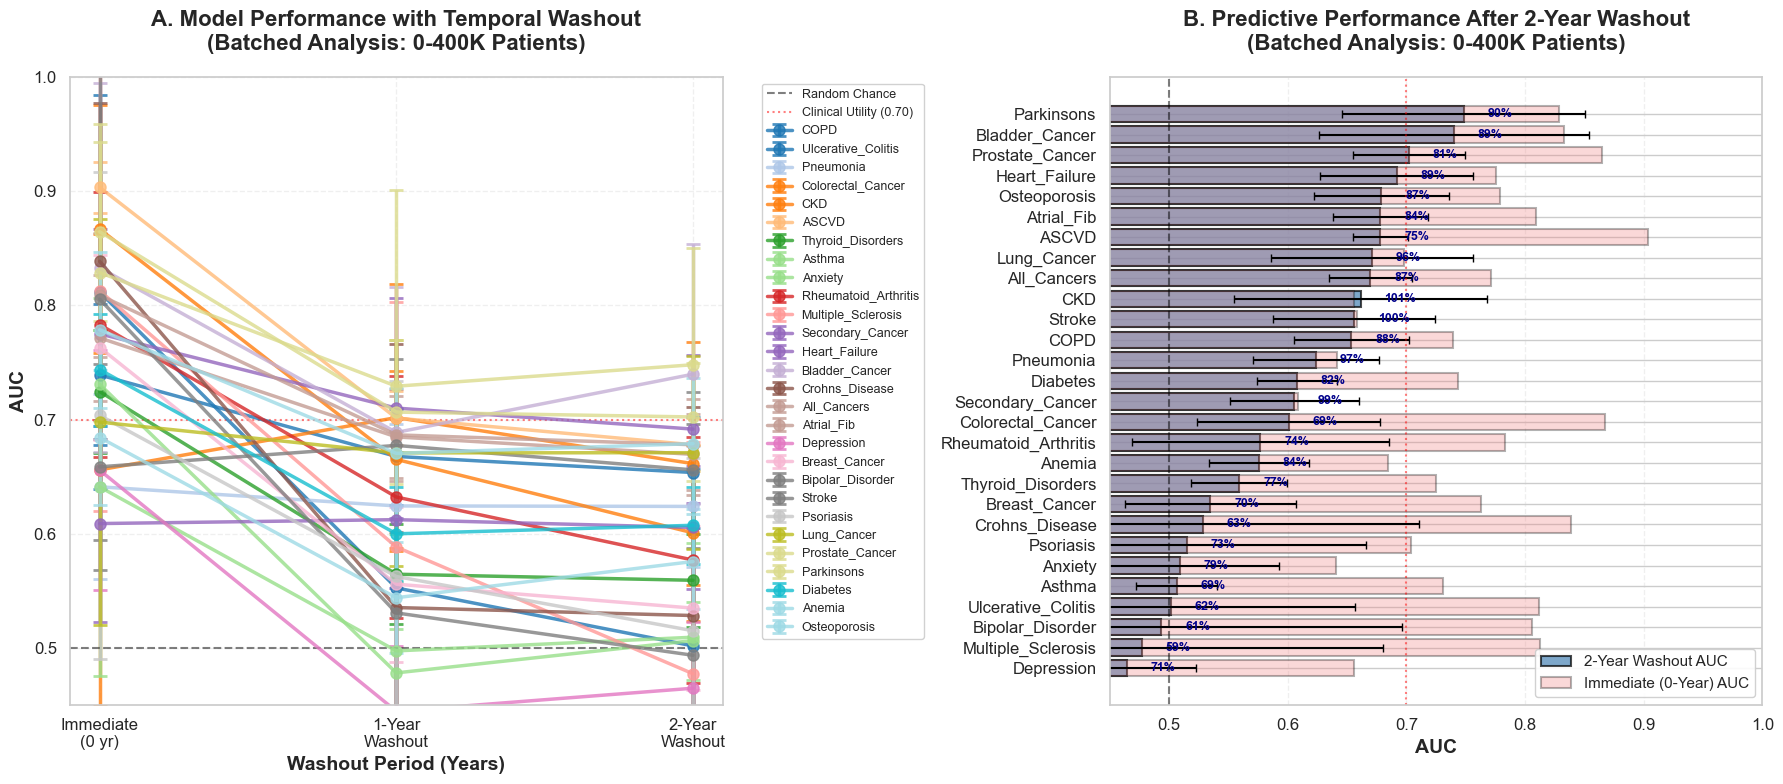


=== CREATING BATCHED SUMMARY TABLE ===
✓ Saved batched washout summary table!


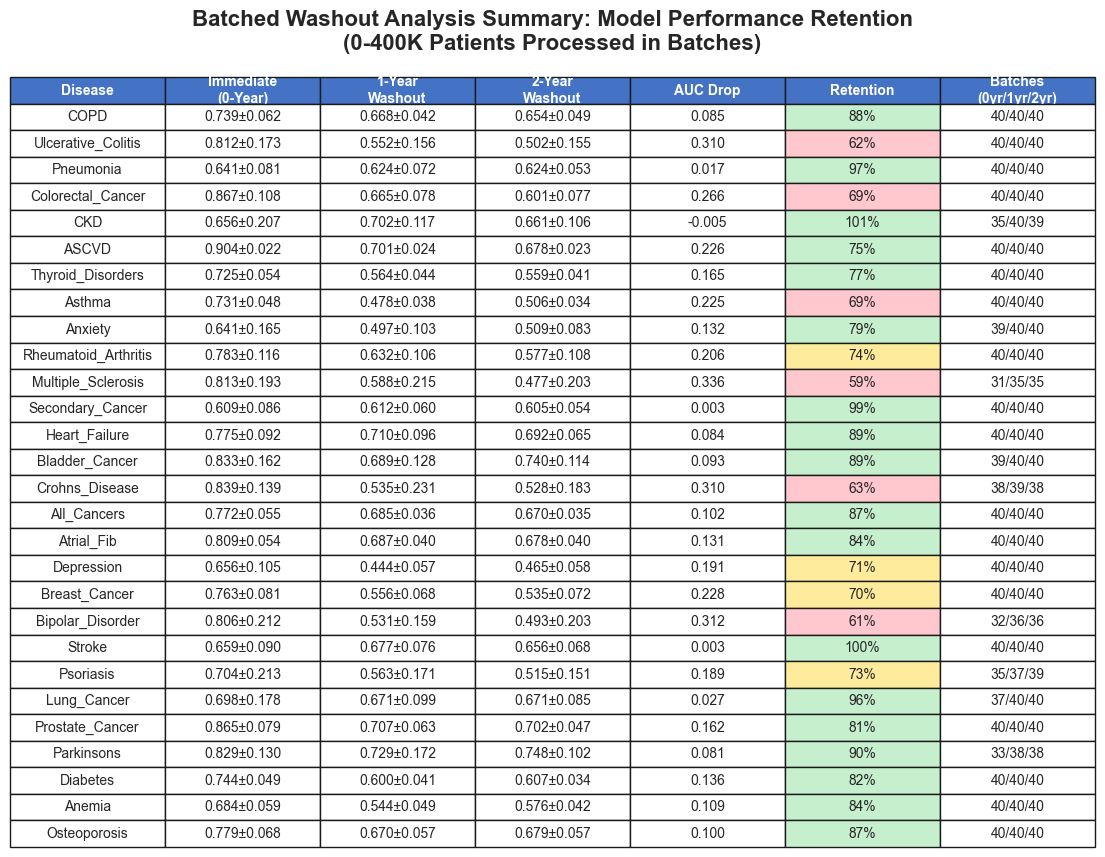


BATCHED WASHOUT ANALYSIS SUMMARY STATISTICS
Analysis Coverage: 0-400K patients processed in batches
Total Diseases Analyzed: 28

Mean AUC at 0-year: 0.755 (SD: 0.079)
Mean AUC at 1-year: 0.617 (SD: 0.079)
Mean AUC at 2-year: 0.604 (SD: 0.084)

Mean AUC drop: 0.151 (SD: 0.101)
Mean retention: 80.6% (SD: 12.4%)

Performance Thresholds at 2-Year Washout:
  AUC > 0.7: 3/28 diseases
  AUC > 0.65: 12/28 diseases
  AUC > 0.6: 16/28 diseases

Batch Coverage:
  Mean batches per disease: 39.2
  Min batches: 31
  Max batches: 40

✅ Batched washout analysis visualization complete!


In [14]:
from plot_batched_washout_results import main as plot_batched_washout_main

# Run the visualization
plot_batched_washout_main()

## use predictions at 41,42

In [15]:
summary_rows = []
for disease in sorted(set().union(*[d.keys() for d in washout_results.values()])):
    row = {"Disease": disease}
    for label in ["0yr", "1yr", "2yr"]:
        metrics = washout_results[label].get(disease)
        if metrics:
            aucs = [a for a in metrics["aucs"] if not pd.isna(a)]
            row[f"{label}_AUC"] = float(np.mean(aucs)) if aucs else np.nan
            row[f"{label}_std"] = float(np.std(aucs, ddof=0)) if aucs else np.nan
            row[f"{label}_batches"] = int(len(aucs))
        else:
            row[f"{label}_AUC"] = np.nan
            row[f"{label}_std"] = np.nan
            row[f"{label}_batches"] = 0
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Disease").reset_index(drop=True)

out_path = "/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv"
summary_df.to_csv(out_path, index=False)
print(f"Saved washout summary to {out_path}")
summary_df.head()

Saved washout summary to /Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv


,Disease,0yr_AUC,0yr_std,0yr_batches,1yr_AUC,1yr_std,1yr_batches,2yr_AUC,2yr_std,2yr_batches
0,ASCVD,0.903571,0.022068,40,0.701358,0.023719,40,0.677964,0.023111,40
1,All_Cancers,0.771633,0.055186,40,0.684820,0.035611,40,0.669532,0.035197,40
2,Anemia,0.684308,0.059123,40,0.543888,0.048699,40,0.575621,0.041960,40
3,Anxiety,0.640999,0.165370,39,0.497305,0.102715,40,0.509284,0.082941,40
4,Asthma,0.730982,0.047785,40,0.477998,0.038514,40,0.506317,0.034172,40


In [ ]:
summary_rows = []
for disease in sorted(set().union(*[d.keys() for d in washout_results.values()])):
    row = {"Disease": disease}
    for label in ["0yr", "1yr", "2yr"]:
        metrics = washout_results[label].get(disease)
        if metrics:
            aucs = [a for a in metrics["aucs"] if not pd.isna(a)]
            events = metrics.get("events", [])
            
            if aucs and len(events) == len(aucs):
                # Weighted mean by number of events (more reliable)
                weights = np.array(events)
                row[f"{label}_AUC"] = float(np.average(aucs, weights=weights))
                
                # Weighted standard deviation
                mean_auc = row[f"{label}_AUC"]
                weighted_var = np.average((aucs - mean_auc)**2, weights=weights)
                row[f"{label}_std"] = float(np.sqrt(weighted_var))
                
                # Standard error of weighted mean
                total_events = np.sum(weights)
                row[f"{label}_SEM"] = float(np.sqrt(weighted_var / total_events)) if total_events > 0 else np.nan
                
                row[f"{label}_batches"] = int(len(aucs))
                row[f"{label}_total_events"] = int(total_events)
            elif aucs:
                # Fallback to simple mean if events not available
                row[f"{label}_AUC"] = float(np.mean(aucs))
                row[f"{label}_std"] = float(np.std(aucs, ddof=0))
                row[f"{label}_SEM"] = float(np.std(aucs, ddof=1) / np.sqrt(len(aucs))) if len(aucs) > 1 else np.nan
                row[f"{label}_batches"] = int(len(aucs))
            else:
                row[f"{label}_AUC"] = np.nan
                row[f"{label}_std"] = np.nan
                row[f"{label}_batches"] = 0
        else:
            row[f"{label}_AUC"] = np.nan
            row[f"{label}_std"] = np.nan
            row[f"{label}_batches"] = 0
    summary_rows.append(row)

# Joint Phi results

# now do with jointly estimated

In [7]:
import glob
import os
import symbol
import sys
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')
from utils import *
import sys
import os
import gc


from clust_huge_amp import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:

ckpt_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs"
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "enrollment_model_W0.0001_batch_*_*.pt")))
initial_psi = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt")
initial_clusters = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt")
signature_refs = torch.load(
    "/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/data_for_running/reference_trajectories.pt"
)["signature_refs"]
fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')

# master tensors; adjust paths if they live elsewhere
E_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt")

washout_results = {"0yr": {}, "1yr": {}, "2yr": {}}
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *

import sys
import os
from contextlib import contextmanager
from io import StringIO

@contextmanager
def suppress_stdout():
    """Context manager to suppress stdout"""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

for ckpt_path in ckpt_paths:
    print(ckpt_path)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    start = ckpt["indices"][0]
    stop = ckpt["indices"][-1]+1

    Y_batch = ckpt["Y"]                        # already saved in checkpoint
    E_batch = E_full[start:stop]               # enrollment covariates
    cov_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    G_batch = ckpt["G"]
    with suppress_stdout():

        model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
            N=Y_batch.shape[0],
            D=Y_batch.shape[1],
            T=Y_batch.shape[2],
            K=20,
            P=G_batch.shape[1],
            init_sd_scaler=1e-1,
            G=G_batch,
            Y=Y_batch.numpy(),
            genetic_scale=1,
            W=0.0001,
            R=0,
            prevalence_t=ckpt["prevalence_t"],
            signature_references=signature_refs,
            healthy_reference=True,
            disease_names=essentials["disease_names"],
        )
        model.initialize_params(true_psi=initial_psi)
        model.clusters = ckpt["clusters"]
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()

        with torch.no_grad():
            pi_batch, _, _ = model.forward()

    for washout_name, offset in [("0yr", 0), ("1yr", 1), ("2yr", 2)]:
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials["disease_names"],
            pce_df=cov_batch,
            n_bootstraps=50,
            follow_up_duration_years=1,
            start_offset=offset,
        )
        for disease, metrics in results.items():
            target = washout_results[washout_name].setdefault(
                disease, {"aucs": [], "cis": [], "events": [], "rates": []}
            )
            target["aucs"].append(metrics["auc"])
            target["cis"].append((metrics["ci_lower"], metrics["ci_upper"]))
            target["events"].append(metrics["n_events"])
            target["rates"].append(metrics["event_rate"])

    del pi_batch, Y_batch, E_batch, cov_batch, G_batch, model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load("/Users/sarahurbut/Libr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_0_10000.pt


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.856 (0.820-0.896)       78         0.8        N/A
Diabetes             0.745 (0.657-0.855)       33         0.3        N/A
Atrial_Fib           0.795 (0.706-0.908)       22         0.2        N/A
CKD                  0.874 (0.549-0.997)       4          0.0        N/A
All_Cancers          0.766 (0.680-0.830)       26         0.3        N/A
Stroke               0.732 (0.655-0.865)       5          0.1        N/A
Heart_Failure        0.842 (0.753-0.955)       15         0.1        N/A
Pneumonia            0.485 (0.392-0.624)       15         0.1        N/A
COPD                 0.728 (0.606-0.850)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4511 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.845-0.925)       88         0.9        N/A
Diabetes             0.717 (0.611-0.808)       34         0.3        N/A
Atrial_Fib           0.789 (0.661-0.890)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.771 (0.661-0.854)       21         0.2        N/A
Stroke               0.765 (0.617-0.903)       7          0.1        N/A
Heart_Failure        0.753 (0.542-0.918)       9          0.1        N/A
Pneumonia            0.513 (0.331-0.608)       19         0.2        N/A
COPD                 0.760 (0.664-0.892)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4599 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.805-0.930)       79         0.8        N/A
Diabetes             0.671 (0.594-0.725)       49         0.5        N/A
Atrial_Fib           0.812 (0.634-0.887)       22         0.2        N/A
CKD                  0.956 (0.909-1.000)       2          0.0        N/A
All_Cancers          0.738 (0.643-0.817)       28         0.3        N/A
Stroke               0.633 (0.518-0.783)       8          0.1        N/A
Heart_Failure        0.757 (0.559-0.910)       10         0.1        N/A
Pneumonia            0.668 (0.538-0.834)       11         0.1        N/A
COPD                 0.735 (0.672-0.816)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.871 (0.820-0.907)       78         0.8        N/A
Diabetes             0.678 (0.599-0.785)       43         0.4        N/A
Atrial_Fib           0.814 (0.717-0.900)       19         0.2        N/A
CKD                  0.634 (0.440-0.774)       5          0.1        N/A
All_Cancers          0.770 (0.687-0.879)       23         0.2        N/A
Stroke               0.696 (0.570-0.939)       7          0.1        N/A
Heart_Failure        0.609 (0.422-0.778)       7          0.1        N/A
Pneumonia            0.718 (0.504-0.884)       7          0.1        N/A
COPD                 0.752 (0.668-0.825)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4498 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.865 (0.819-0.907)       86         0.9        N/A
Diabetes             0.660 (0.531-0.769)       34         0.3        N/A
Atrial_Fib           0.727 (0.625-0.836)       33         0.3        N/A
CKD                  0.803 (0.599-0.998)       2          0.0        N/A
All_Cancers          0.808 (0.690-0.932)       12         0.1        N/A
Stroke               0.618 (0.341-0.959)       4          0.0        N/A
Heart_Failure        0.902 (0.811-0.970)       11         0.1        N/A
Pneumonia            0.515 (0.296-0.665)       10         0.1        N/A
COPD                 0.676 (0.576-0.773)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4536 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.892 (0.858-0.923)       91         0.9        N/A
Diabetes             0.671 (0.574-0.756)       43         0.4        N/A
Atrial_Fib           0.843 (0.736-0.935)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.741 (0.650-0.855)       17         0.2        N/A
Stroke               0.644 (0.501-0.786)       15         0.1        N/A
Heart_Failure        0.851 (0.756-0.962)       11         0.1        N/A
Pneumonia            0.624 (0.481-0.738)       18         0.2        N/A
COPD                 0.660 (0.558-0.755)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4564 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.873 (0.830-0.905)       98         1.0        N/A
Diabetes             0.753 (0.672-0.801)       57         0.6        N/A
Atrial_Fib           0.911 (0.747-0.999)       10         0.1        N/A
CKD                  0.692 (0.467-0.908)       7          0.1        N/A
All_Cancers          0.732 (0.606-0.862)       24         0.2        N/A
Stroke               0.753 (0.524-0.925)       11         0.1        N/A
Heart_Failure        0.729 (0.609-0.888)       8          0.1        N/A
Pneumonia            0.586 (0.429-0.755)       9          0.1        N/A
COPD                 0.699 (0.558-0.873)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4592 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.885 (0.826-0.926)       65         0.7        N/A
Diabetes             0.723 (0.628-0.842)       29         0.3        N/A
Atrial_Fib           0.749 (0.641-0.862)       27         0.3        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.865 (0.777-0.916)       17         0.2        N/A
Stroke               0.842 (0.746-0.969)       6          0.1        N/A
Heart_Failure        0.710 (0.505-0.913)       11         0.1        N/A
Pneumonia            0.526 (0.309-0.713)       9          0.1        N/A
COPD                 0.689 (0.411-0.990)       5          0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4624 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.909 (0.875-0.938)       88         0.9        N/A
Diabetes             0.753 (0.686-0.877)       39         0.4        N/A
Atrial_Fib           0.850 (0.770-0.927)       33         0.3        N/A
CKD                  0.456 (0.238-0.740)       3          0.0        N/A
All_Cancers          0.747 (0.635-0.830)       31         0.3        N/A
Stroke               0.634 (0.451-0.751)       8          0.1        N/A
Heart_Failure        0.752 (0.601-0.911)       11         0.1        N/A
Pneumonia            0.573 (0.409-0.718)       13         0.1        N/A
COPD                 0.757 (0.664-0.847)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4584 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.912 (0.866-0.940)       103        1.0        N/A
Diabetes             0.762 (0.692-0.843)       32         0.3        N/A
Atrial_Fib           0.733 (0.628-0.892)       17         0.2        N/A
CKD                  0.639 (0.150-0.960)       3          0.0        N/A
All_Cancers          0.827 (0.710-0.931)       22         0.2        N/A
Stroke               0.758 (0.607-0.869)       10         0.1        N/A
Heart_Failure        0.793 (0.695-0.896)       16         0.2        N/A
Pneumonia            0.738 (0.619-0.835)       15         0.1        N/A
COPD                 0.747 (0.607-0.837)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4608 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.846-0.929)       90         0.9        N/A
Diabetes             0.736 (0.668-0.817)       54         0.5        N/A
Atrial_Fib           0.843 (0.771-0.955)       17         0.2        N/A
CKD                  0.820 (0.812-0.827)       1          0.0        N/A
All_Cancers          0.829 (0.743-0.887)       24         0.2        N/A
Stroke               0.612 (0.484-0.741)       10         0.1        N/A
Heart_Failure        0.554 (0.312-0.744)       6          0.1        N/A
Pneumonia            0.572 (0.416-0.715)       11         0.1        N/A
COPD                 0.732 (0.630-0.834)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4538 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.893 (0.850-0.936)       63         0.6        N/A
Diabetes             0.756 (0.699-0.830)       51         0.5        N/A
Atrial_Fib           0.704 (0.519-0.818)       21         0.2        N/A
CKD                  0.638 (0.524-0.756)       2          0.0        N/A
All_Cancers          0.767 (0.689-0.843)       29         0.3        N/A
Stroke               0.629 (0.321-0.879)       5          0.1        N/A
Heart_Failure        0.717 (0.532-0.842)       10         0.1        N/A
Pneumonia            0.540 (0.312-0.704)       11         0.1        N/A
COPD                 0.664 (0.556-0.808)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4707 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.854 (0.787-0.908)       67         0.7        N/A
Diabetes             0.624 (0.535-0.705)       49         0.5        N/A
Atrial_Fib           0.816 (0.756-0.907)       25         0.2        N/A
CKD                  0.475 (0.197-0.773)       4          0.0        N/A
All_Cancers          0.766 (0.684-0.854)       21         0.2        N/A
Stroke               0.530 (0.283-0.632)       7          0.1        N/A
Heart_Failure        0.693 (0.533-0.884)       9          0.1        N/A
Pneumonia            0.692 (0.578-0.778)       22         0.2        N/A
COPD                 0.776 (0.691-0.853)       32         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4605 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.875 (0.829-0.912)       78         0.8        N/A
Diabetes             0.678 (0.599-0.755)       44         0.4        N/A
Atrial_Fib           0.863 (0.731-0.987)       16         0.2        N/A
CKD                  0.665 (0.456-0.817)       4          0.0        N/A
All_Cancers          0.795 (0.699-0.854)       19         0.2        N/A
Stroke               0.532 (0.424-0.685)       5          0.1        N/A
Heart_Failure        0.777 (0.731-0.883)       12         0.1        N/A
Pneumonia            0.701 (0.441-0.834)       8          0.1        N/A
COPD                 0.714 (0.613-0.819)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4543 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.912 (0.878-0.945)       65         0.7        N/A
Diabetes             0.805 (0.710-0.873)       47         0.5        N/A
Atrial_Fib           0.833 (0.743-0.913)       22         0.2        N/A
CKD                  0.705 (0.548-0.907)       5          0.1        N/A
All_Cancers          0.782 (0.684-0.864)       19         0.2        N/A
Stroke               0.804 (0.725-0.900)       7          0.1        N/A
Heart_Failure        0.724 (0.553-0.853)       10         0.1        N/A
Pneumonia            0.613 (0.495-0.758)       15         0.1        N/A
COPD                 0.676 (0.565-0.753)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4612 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.819 (0.779-0.882)       92         0.9        N/A
Diabetes             0.762 (0.701-0.839)       45         0.4        N/A
Atrial_Fib           0.765 (0.648-0.852)       26         0.3        N/A
CKD                  0.669 (0.500-0.797)       5          0.1        N/A
All_Cancers          0.829 (0.735-0.909)       23         0.2        N/A
Stroke               0.727 (0.602-0.857)       8          0.1        N/A
Heart_Failure        0.773 (0.610-0.934)       6          0.1        N/A
Pneumonia            0.585 (0.461-0.704)       19         0.2        N/A
COPD                 0.594 (0.505-0.715)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4676 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.902 (0.872-0.937)       74         0.7        N/A
Diabetes             0.742 (0.664-0.844)       39         0.4        N/A
Atrial_Fib           0.836 (0.712-0.953)       22         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.742 (0.667-0.811)       21         0.2        N/A
Stroke               0.652 (0.535-0.773)       13         0.1        N/A
Heart_Failure        0.806 (0.579-0.991)       9          0.1        N/A
Pneumonia            0.587 (0.362-0.753)       13         0.1        N/A
COPD                 0.718 (0.610-0.821)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4579 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.856 (0.801-0.901)       77         0.8        N/A
Diabetes             0.754 (0.662-0.829)       40         0.4        N/A
Atrial_Fib           0.771 (0.647-0.874)       28         0.3        N/A
CKD                  0.374 (0.323-0.426)       2          0.0        N/A
All_Cancers          0.810 (0.738-0.872)       34         0.3        N/A
Stroke               0.542 (0.341-0.662)       11         0.1        N/A
Heart_Failure        0.732 (0.543-0.862)       10         0.1        N/A
Pneumonia            0.646 (0.492-0.749)       16         0.2        N/A
COPD                 0.762 (0.683-0.840)       25         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4553 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.902 (0.859-0.937)       88         0.9        N/A
Diabetes             0.743 (0.656-0.837)       39         0.4        N/A
Atrial_Fib           0.800 (0.711-0.863)       31         0.3        N/A
CKD                  0.266 (0.056-0.479)       2          0.0        N/A
All_Cancers          0.762 (0.694-0.835)       34         0.3        N/A
Stroke               0.530 (0.100-0.980)       4          0.0        N/A
Heart_Failure        0.805 (0.590-0.985)       8          0.1        N/A
Pneumonia            0.674 (0.528-0.807)       11         0.1        N/A
COPD                 0.844 (0.708-0.918)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4603 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.873 (0.826-0.921)       80         0.8        N/A
Diabetes             0.719 (0.648-0.793)       48         0.5        N/A
Atrial_Fib           0.824 (0.706-0.939)       21         0.2        N/A
CKD                  0.568 (0.256-0.876)       2          0.0        N/A
All_Cancers          0.661 (0.586-0.741)       27         0.3        N/A
Stroke               0.778 (0.714-0.896)       8          0.1        N/A
Heart_Failure        0.891 (0.729-0.968)       10         0.1        N/A
Pneumonia            0.700 (0.363-0.867)       7          0.1        N/A
COPD                 0.709 (0.584-0.775)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4546 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.857-0.919)       96         1.0        N/A
Diabetes             0.688 (0.624-0.756)       38         0.4        N/A
Atrial_Fib           0.802 (0.712-0.871)       21         0.2        N/A
CKD                  0.620 (0.330-0.782)       7          0.1        N/A
All_Cancers          0.803 (0.720-0.869)       22         0.2        N/A
Stroke               0.475 (0.292-0.683)       9          0.1        N/A
Heart_Failure        0.666 (0.374-0.926)       7          0.1        N/A
Pneumonia            0.582 (0.423-0.732)       15         0.1        N/A
COPD                 0.714 (0.630-0.790)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4522 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.895 (0.861-0.928)       81         0.8        N/A
Diabetes             0.719 (0.565-0.837)       35         0.4        N/A
Atrial_Fib           0.730 (0.643-0.900)       28         0.3        N/A
CKD                  0.574 (0.093-1.000)       4          0.0        N/A
All_Cancers          0.744 (0.599-0.871)       18         0.2        N/A
Stroke               0.514 (0.361-0.641)       8          0.1        N/A
Heart_Failure        0.646 (0.423-0.938)       10         0.1        N/A
Pneumonia            0.678 (0.483-0.843)       11         0.1        N/A
COPD                 0.694 (0.608-0.804)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4558 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.861 (0.810-0.888)       98         1.0        N/A
Diabetes             0.746 (0.667-0.829)       39         0.4        N/A
Atrial_Fib           0.798 (0.733-0.857)       25         0.2        N/A
CKD                  0.861 (0.595-0.960)       4          0.0        N/A
All_Cancers          0.618 (0.516-0.767)       16         0.2        N/A
Stroke               0.656 (0.573-0.816)       11         0.1        N/A
Heart_Failure        0.734 (0.609-0.854)       13         0.1        N/A
Pneumonia            0.509 (0.368-0.624)       14         0.1        N/A
COPD                 0.773 (0.715-0.863)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4532 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.861 (0.810-0.897)       85         0.9        N/A
Diabetes             0.774 (0.708-0.841)       48         0.5        N/A
Atrial_Fib           0.850 (0.767-0.945)       18         0.2        N/A
CKD                  0.687 (0.473-0.899)       2          0.0        N/A
All_Cancers          0.753 (0.646-0.863)       33         0.3        N/A
Stroke               0.657 (0.494-0.816)       8          0.1        N/A
Heart_Failure        0.929 (0.738-0.997)       6          0.1        N/A
Pneumonia            0.526 (0.375-0.641)       12         0.1        N/A
COPD                 0.660 (0.557-0.790)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.835 (0.768-0.883)       88         0.9        N/A
Diabetes             0.765 (0.684-0.875)       36         0.4        N/A
Atrial_Fib           0.868 (0.838-0.919)       35         0.4        N/A
CKD                  0.318 (0.064-0.615)       4          0.0        N/A
All_Cancers          0.725 (0.656-0.808)       28         0.3        N/A
Stroke               0.675 (0.473-0.822)       9          0.1        N/A
Heart_Failure        0.884 (0.810-0.987)       7          0.1        N/A
Pneumonia            0.637 (0.474-0.908)       8          0.1        N/A
COPD                 0.668 (0.536-0.805)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4473 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.825-0.932)       70         0.7        N/A
Diabetes             0.719 (0.651-0.808)       46         0.5        N/A
Atrial_Fib           0.765 (0.677-0.879)       32         0.3        N/A
CKD                  0.869 (0.739-0.997)       2          0.0        N/A
All_Cancers          0.744 (0.616-0.846)       25         0.2        N/A
Stroke               0.684 (0.569-0.786)       6          0.1        N/A
Heart_Failure        0.925 (0.873-0.971)       4          0.0        N/A
Pneumonia            0.700 (0.393-0.944)       4          0.0        N/A
COPD                 0.765 (0.628-0.818)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4550 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.857 (0.810-0.884)       87         0.9        N/A
Diabetes             0.728 (0.634-0.815)       43         0.4        N/A
Atrial_Fib           0.693 (0.520-0.830)       16         0.2        N/A
CKD                  0.579 (0.324-0.807)       4          0.0        N/A
All_Cancers          0.670 (0.545-0.775)       18         0.2        N/A
Stroke               0.770 (0.718-0.861)       8          0.1        N/A
Heart_Failure        0.710 (0.581-0.827)       9          0.1        N/A
Pneumonia            0.784 (0.563-0.929)       8          0.1        N/A
COPD                 0.731 (0.644-0.853)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4686 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.831 (0.779-0.887)       71         0.7        N/A
Diabetes             0.701 (0.613-0.789)       39         0.4        N/A
Atrial_Fib           0.774 (0.698-0.882)       26         0.3        N/A
CKD                  0.067 (0.063-0.070)       1          0.0        N/A
All_Cancers          0.780 (0.686-0.887)       15         0.1        N/A
Stroke               0.596 (0.460-0.753)       9          0.1        N/A
Heart_Failure        0.830 (0.725-0.985)       6          0.1        N/A
Pneumonia            0.792 (0.646-0.913)       13         0.1        N/A
COPD                 0.589 (0.432-0.712)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4586 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.898 (0.842-0.936)       81         0.8        N/A
Diabetes             0.671 (0.601-0.774)       38         0.4        N/A
Atrial_Fib           0.823 (0.718-0.914)       21         0.2        N/A
CKD                  0.935 (0.845-1.000)       4          0.0        N/A
All_Cancers          0.757 (0.654-0.840)       26         0.3        N/A
Stroke               0.579 (0.416-0.842)       3          0.0        N/A
Heart_Failure        0.714 (0.183-1.000)       3          0.0        N/A
Pneumonia            0.589 (0.452-0.724)       17         0.2        N/A
COPD                 0.728 (0.650-0.849)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4492 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.857 (0.803-0.898)       68         0.7        N/A
Diabetes             0.676 (0.566-0.797)       37         0.4        N/A
Atrial_Fib           0.740 (0.551-0.862)       19         0.2        N/A
CKD                  0.688 (0.427-0.879)       3          0.0        N/A
All_Cancers          0.794 (0.684-0.881)       25         0.2        N/A
Stroke               0.681 (0.431-0.884)       5          0.1        N/A
Heart_Failure        0.760 (0.604-0.938)       12         0.1        N/A
Pneumonia            0.635 (0.478-0.741)       19         0.2        N/A
COPD                 0.654 (0.601-0.766)       23         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.820-0.904)       73         0.7        N/A
Diabetes             0.767 (0.684-0.833)       36         0.4        N/A
Atrial_Fib           0.750 (0.558-0.877)       13         0.1        N/A
CKD                  0.819 (0.632-0.999)       2          0.0        N/A
All_Cancers          0.727 (0.661-0.802)       26         0.3        N/A
Stroke               0.584 (0.408-0.737)       10         0.1        N/A
Heart_Failure        0.710 (0.535-0.875)       8          0.1        N/A
Pneumonia            0.698 (0.581-0.807)       15         0.1        N/A
COPD                 0.674 (0.464-0.847)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.844 (0.806-0.897)       97         1.0        N/A
Diabetes             0.709 (0.611-0.791)       47         0.5        N/A
Atrial_Fib           0.787 (0.707-0.893)       31         0.3        N/A
CKD                  0.589 (0.575-0.597)       1          0.0        N/A
All_Cancers          0.724 (0.602-0.823)       22         0.2        N/A
Stroke               0.553 (0.376-0.747)       8          0.1        N/A
Heart_Failure        0.833 (0.571-0.990)       5          0.1        N/A
Pneumonia            0.655 (0.559-0.789)       16         0.2        N/A
COPD                 0.698 (0.640-0.779)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4523 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.843 (0.799-0.881)       87         0.9        N/A
Diabetes             0.685 (0.604-0.764)       44         0.4        N/A
Atrial_Fib           0.769 (0.629-0.890)       21         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.673 (0.550-0.776)       36         0.4        N/A
Stroke               0.770 (0.650-0.898)       5          0.1        N/A
Heart_Failure        0.667 (0.529-0.819)       10         0.1        N/A
Pneumonia            0.661 (0.488-0.809)       13         0.1        N/A
COPD                 0.564 (0.486-0.706)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4436 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.869 (0.818-0.916)       80         0.8        N/A
Diabetes             0.671 (0.615-0.776)       47         0.5        N/A
Atrial_Fib           0.919 (0.850-0.970)       28         0.3        N/A
CKD                  0.829 (0.528-1.000)       3          0.0        N/A
All_Cancers          0.776 (0.647-0.871)       18         0.2        N/A
Stroke               0.592 (0.368-0.746)       10         0.1        N/A
Heart_Failure        0.687 (0.294-0.923)       6          0.1        N/A
Pneumonia            0.687 (0.547-0.829)       14         0.1        N/A
COPD                 0.679 (0.554-0.771)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.815-0.915)       74         0.7        N/A
Diabetes             0.624 (0.517-0.752)       33         0.3        N/A
Atrial_Fib           0.850 (0.770-0.917)       25         0.2        N/A
CKD                  0.774 (0.549-0.998)       2          0.0        N/A
All_Cancers          0.725 (0.627-0.859)       14         0.1        N/A
Stroke               0.770 (0.691-0.831)       3          0.0        N/A
Heart_Failure        0.725 (0.457-0.988)       7          0.1        N/A
Pneumonia            0.586 (0.437-0.768)       14         0.1        N/A
COPD                 0.649 (0.549-0.737)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4537 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.897 (0.849-0.943)       72         0.7        N/A
Diabetes             0.682 (0.601-0.780)       43         0.4        N/A
Atrial_Fib           0.816 (0.675-0.922)       24         0.2        N/A
CKD                  0.307 (0.154-0.551)       4          0.0        N/A
All_Cancers          0.715 (0.606-0.792)       34         0.3        N/A
Stroke               0.562 (0.198-0.839)       5          0.1        N/A
Heart_Failure        0.894 (0.793-0.991)       6          0.1        N/A
Pneumonia            0.594 (0.487-0.715)       10         0.1        N/A
COPD                 0.833 (0.725-0.924)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4577 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.844 (0.780-0.881)       76         0.8        N/A
Diabetes             0.624 (0.527-0.738)       36         0.4        N/A
Atrial_Fib           0.784 (0.641-0.929)       15         0.1        N/A
CKD                  0.591 (0.108-0.886)       3          0.0        N/A
All_Cancers          0.757 (0.640-0.858)       24         0.2        N/A
Stroke               0.763 (0.675-0.884)       4          0.0        N/A
Heart_Failure        0.749 (0.631-0.852)       16         0.2        N/A
Pneumonia            0.596 (0.436-0.725)       12         0.1        N/A
COPD                 0.792 (0.689-0.860)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.852 (0.812-0.888)       96         1.0        N/A
Diabetes             0.711 (0.640-0.792)       44         0.4        N/A
Atrial_Fib           0.784 (0.672-0.888)       21         0.2        N/A
CKD                  0.544 (0.539-0.554)       1          0.0        N/A
All_Cancers          0.763 (0.681-0.849)       21         0.2        N/A
Stroke               0.696 (0.533-0.827)       11         0.1        N/A
Heart_Failure        0.860 (0.737-0.956)       8          0.1        N/A
Pneumonia            0.748 (0.543-0.890)       8          0.1        N/A
COPD                 0.675 (0.580-0.790)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4609 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.861 (0.813-0.908)       81         0.8        N/A
Diabetes             0.684 (0.578-0.745)       48         0.5        N/A
Atrial_Fib           0.800 (0.601-0.903)       14         0.1        N/A
CKD                  0.510 (0.155-0.800)       5          0.1        N/A
All_Cancers          0.822 (0.710-0.901)       24         0.2        N/A
Stroke               0.682 (0.483-0.835)       8          0.1        N/A
Heart_Failure        0.610 (0.355-0.820)       8          0.1        N/A
Pneumonia            0.611 (0.508-0.758)       16         0.2        N/A
COPD                 0.700 (0.624-0.774)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/40915587.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu"

Filtering for 1: Found 4440 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.850-0.924)       79         0.8        N/A
Diabetes             0.775 (0.699-0.829)       36         0.4        N/A
Atrial_Fib           0.785 (0.652-0.872)       21         0.2        N/A
CKD                  0.882 (0.788-0.971)       4          0.0        N/A
All_Cancers          0.804 (0.705-0.870)       23         0.2        N/A
Stroke               0.613 (0.325-0.804)       4          0.0        N/A
Heart_Failure        0.735 (0.549-0.929)       8          0.1        N/A
Pneumonia            0.648 (0.562-0.780)       13         0.1        N/A
COPD                 0.718 (0.657-0.807)       28         0.3    

In [7]:
# Save the washout_results object
import torch
import os

# Create the output directory if it doesn't exist
output_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal"
os.makedirs(output_dir, exist_ok=True)

# Save the results
output_file = os.path.join(output_dir, "full_washout_results_0_400k_withpcs_joint1114.pt")

#output_file = os.path.join(output_dir, "full_washout_results_0_400k.pt")
#output_file = os.path.join(output_dir, "full_washout_results_0_30k.pt")
torch.save(washout_results, output_file)

print(f"Washout results saved to: {output_file}")
print(f"Saved {len(washout_results)} washout periods")

Washout results saved to: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/full_washout_results_0_400k_withpcs_joint1114.pt
Saved 3 washout periods


In [8]:
summary_rows = []
for disease in sorted(set().union(*[d.keys() for d in washout_results.values()])):
    row = {"Disease": disease}
    for label in ["0yr", "1yr", "2yr"]:
        metrics = washout_results[label].get(disease)
        if metrics:
            aucs = [a for a in metrics["aucs"] if not pd.isna(a)]
            row[f"{label}_AUC"] = float(np.mean(aucs)) if aucs else np.nan
            row[f"{label}_std"] = float(np.std(aucs, ddof=0)) if aucs else np.nan
            row[f"{label}_batches"] = int(len(aucs))
        else:
            row[f"{label}_AUC"] = np.nan
            row[f"{label}_std"] = np.nan
            row[f"{label}_batches"] = 0
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Disease").reset_index(drop=True)

out_path = "/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1123_fixedpooledretro.csv"
summary_df.to_csv(out_path, index=False)
print(f"Saved washout summary to {out_path}")
summary_df

Saved washout summary to /Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1123_fixedpooledretro.csv


,Disease,0yr_AUC,0yr_std,0yr_batches,1yr_AUC,1yr_std,1yr_batches,2yr_AUC,2yr_std,2yr_batches
0,ASCVD,0.895026,0.021614,40,0.755624,0.026414,40,0.741729,0.016708,40
1,All_Cancers,0.766393,0.053757,40,0.694118,0.037378,40,0.678587,0.035548,40
2,Anemia,0.673659,0.058352,40,0.543554,0.048881,40,0.574829,0.042750,40
3,Anxiety,0.653645,0.158509,39,0.506307,0.114147,40,0.512937,0.088790,40
4,Asthma,0.730252,0.046412,40,0.495692,0.033911,40,0.525921,0.034681,40
5,Atrial_Fib,0.816809,0.052995,40,0.696518,0.042586,40,0.688242,0.042456,40
6,Bipolar_Disorder,0.810685,0.218586,32,0.494780,0.164276,36,0.495683,0.227204,36
7,Bladder_Cancer,0.835205,0.163948,39,0.699570,0.125823,40,0.764945,0.118796,40
8,Breast_Cancer,0.817607,0.074041,40,0.585634,0.069685,40,0.571354,0.073033,40
9,CKD,0.647661,0.202964,35,0.701219,0.119894,40,0.658029,0.103269,39


In [15]:
summary_rows = []
for disease in sorted(set().union(*[d.keys() for d in washout_results.values()])):
    row = {"Disease": disease}
    for label in ["0yr", "1yr", "2yr"]:
        metrics = washout_results[label].get(disease)
        if metrics:
            aucs = [a for a in metrics["aucs"] if not pd.isna(a)]
            row[f"{label}_AUC"] = float(np.mean(aucs)) if aucs else np.nan
            row[f"{label}_std"] = float(np.std(aucs, ddof=0)) if aucs else np.nan
            row[f"{label}_batches"] = int(len(aucs))
        else:
            row[f"{label}_AUC"] = np.nan
            row[f"{label}_std"] = np.nan
            row[f"{label}_batches"] = 0
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Disease").reset_index(drop=True)

out_path = "/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1114.csv"
summary_df.to_csv(out_path, index=False)
print(f"Saved washout summary to {out_path}")
summary_df

Saved washout summary to /Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1114.csv


,Disease,0yr_AUC,0yr_std,0yr_batches,1yr_AUC,1yr_std,1yr_batches,2yr_AUC,2yr_std,2yr_batches
0,ASCVD,0.872402,0.022732,40,0.731617,0.027407,40,0.707960,0.020613,40
1,All_Cancers,0.759586,0.049177,40,0.692967,0.034200,40,0.677329,0.035746,40
2,Anemia,0.646599,0.057465,40,0.543389,0.046990,40,0.573640,0.043762,40
3,Anxiety,0.584665,0.158343,39,0.506398,0.109814,40,0.510883,0.087208,40
4,Asthma,0.694322,0.041985,40,0.502176,0.033467,40,0.529978,0.032850,40
5,Atrial_Fib,0.799143,0.050150,40,0.656861,0.043977,40,0.625129,0.044507,40
6,Bipolar_Disorder,0.845111,0.193149,32,0.472716,0.186708,36,0.469681,0.190892,36
7,Bladder_Cancer,0.835086,0.165121,39,0.699140,0.120324,40,0.756226,0.114984,40
8,Breast_Cancer,0.759026,0.068719,40,0.554764,0.074114,40,0.549726,0.073175,40
9,CKD,0.636508,0.201252,35,0.702045,0.119122,40,0.657967,0.104861,39


compare each joint and phi per offset.


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8851/1705436665.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


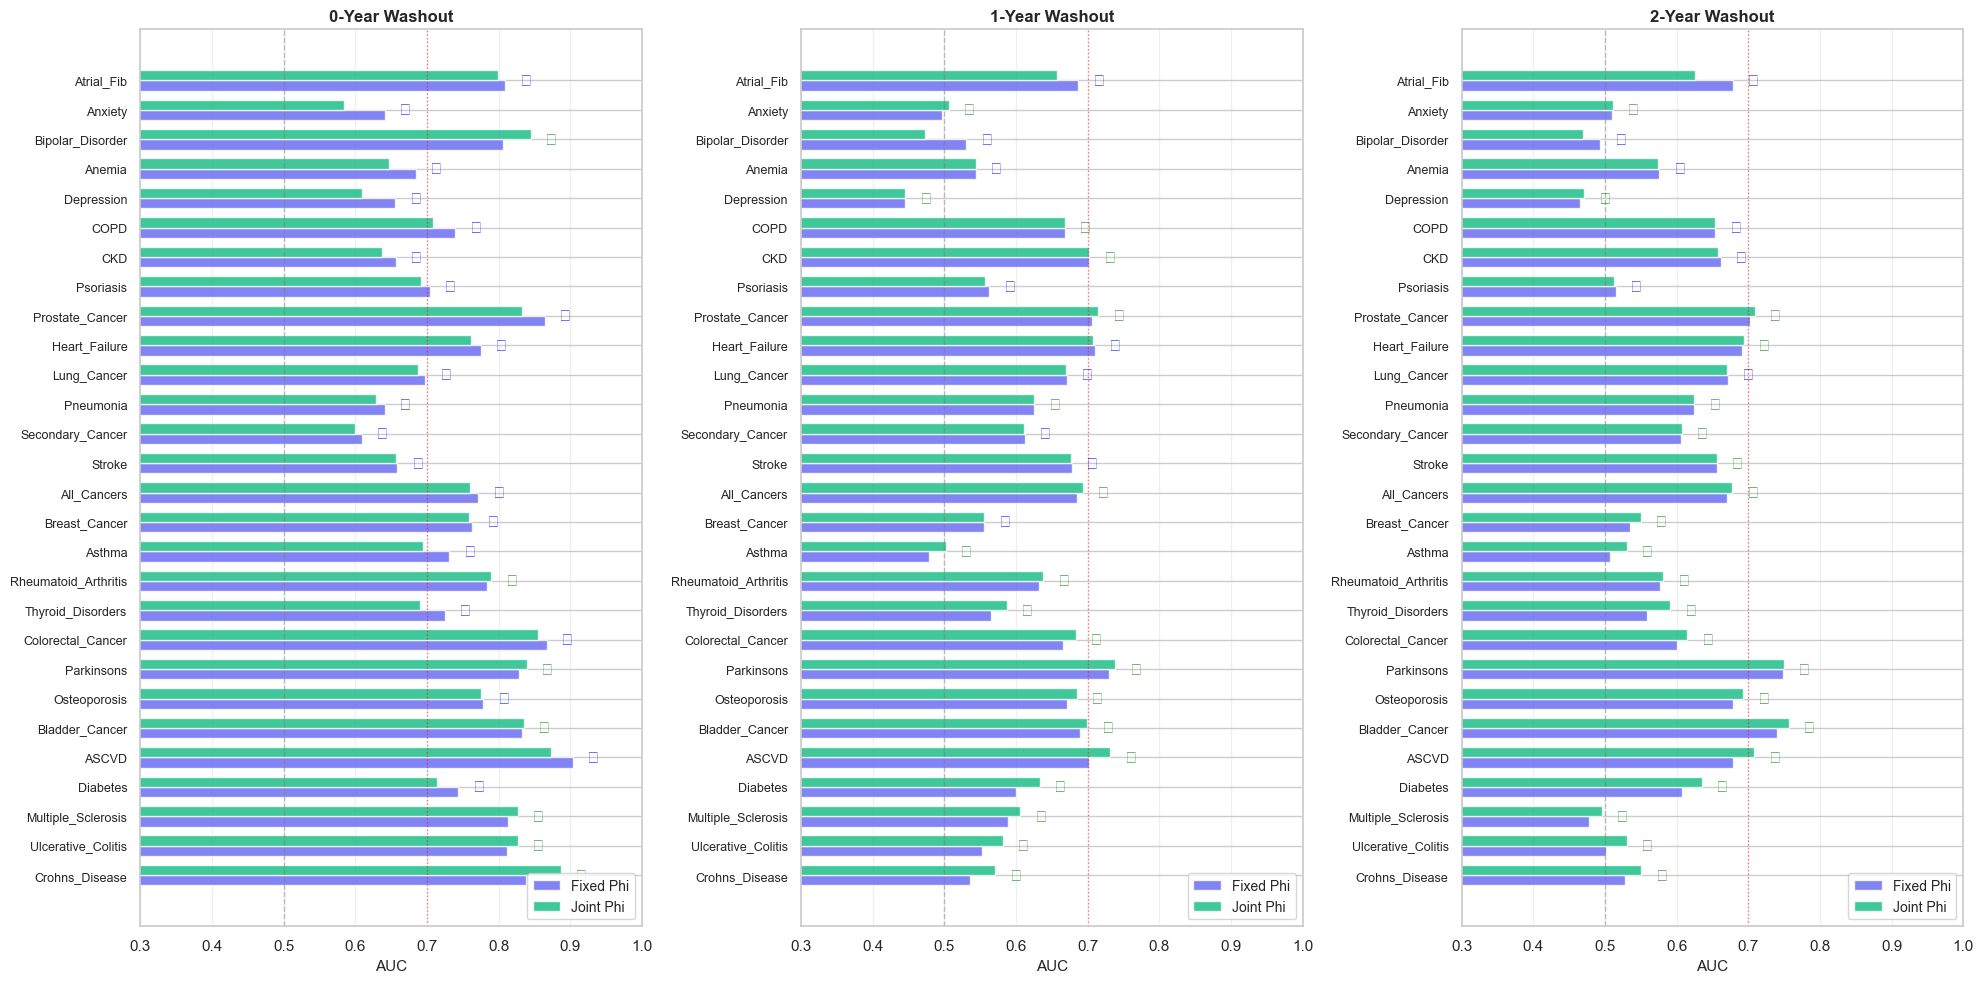


=== Summary: Joint vs Fixed Phi ===

0-Year Washout:
  Joint better: 7 diseases
  Fixed better: 21 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): -0.0115

1-Year Washout:
  Joint better: 19 diseases
  Fixed better: 9 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): 0.0064

2-Year Washout:
  Joint better: 21 diseases
  Fixed better: 7 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): 0.0067



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
fixed_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv")
joint_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1114.csv")

# Merge on Disease
comparison_df = fixed_df[["Disease"]].merge(
    fixed_df[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC"]].rename(
        columns={"0yr_AUC": "fixed_0yr", "1yr_AUC": "fixed_1yr", "2yr_AUC": "fixed_2yr"}
    ),
    on="Disease"
).merge(
    joint_df[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC"]].rename(
        columns={"0yr_AUC": "joint_0yr", "1yr_AUC": "joint_1yr", "2yr_AUC": "joint_2yr"}
    ),
    on="Disease"
)

# Calculate differences (positive = joint better, negative = fixed better)
for period in ["0yr", "1yr", "2yr"]:
    comparison_df[f"diff_{period}"] = comparison_df[f"joint_{period}"] - comparison_df[f"fixed_{period}"]

# Sort by average difference across periods for better visualization
comparison_df["avg_diff"] = comparison_df[["diff_0yr", "diff_1yr", "diff_2yr"]].mean(axis=1)
comparison_df = comparison_df.sort_values("avg_diff", ascending=False).reset_index(drop=True)

# Create three plots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
periods = ["0yr", "1yr", "2yr"]
titles = ["0-Year Washout", "1-Year Washout", "2-Year Washout"]

for idx, (period, title) in enumerate(zip(periods, titles)):
    ax = axes[idx]
    x = np.arange(len(comparison_df))
    width = 0.35
    
    fixed_aucs = comparison_df[f"fixed_{period}"].values
    joint_aucs = comparison_df[f"joint_{period}"].values
    
    # Create bars
    bars1 = ax.barh(x - width/2, fixed_aucs, width, label='Fixed Phi', color='#6366f1', alpha=0.8)
    bars2 = ax.barh(x + width/2, joint_aucs, width, label='Joint Phi', color='#10b981', alpha=0.8)
    
    # Add vertical line at 0.5 (random performance)
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(0.7, color='red', linestyle=':', linewidth=1, alpha=0.5)
    
    # Add text annotations showing which is better
    for i, (fixed, joint) in enumerate(zip(fixed_aucs, joint_aucs)):
        if not (pd.isna(fixed) or pd.isna(joint)):
            if joint > fixed:
                ax.text(max(fixed, joint) + 0.02, i, '✓', color='green', fontsize=12, fontweight='bold', va='center')
            elif fixed > joint:
                ax.text(max(fixed, joint) + 0.02, i, '✓', color='blue', fontsize=12, fontweight='bold', va='center')
    
    ax.set_yticks(x)
    ax.set_yticklabels(comparison_df["Disease"], fontsize=9)
    ax.set_xlabel('AUC', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0.3, 1.0)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary: Joint vs Fixed Phi ===\n")
for period, title in zip(periods, titles):
    diff = comparison_df[f"diff_{period}"].dropna()
    joint_better = (diff > 0).sum()
    fixed_better = (diff < 0).sum()
    ties = (diff == 0).sum()
    mean_diff = diff.mean()
    
    print(f"{title}:")
    print(f"  Joint better: {joint_better} diseases")
    print(f"  Fixed better: {fixed_better} diseases")
    print(f"  Ties: {ties} diseases")
    print(f"  Mean difference (joint - fixed): {mean_diff:.4f}")
    print()

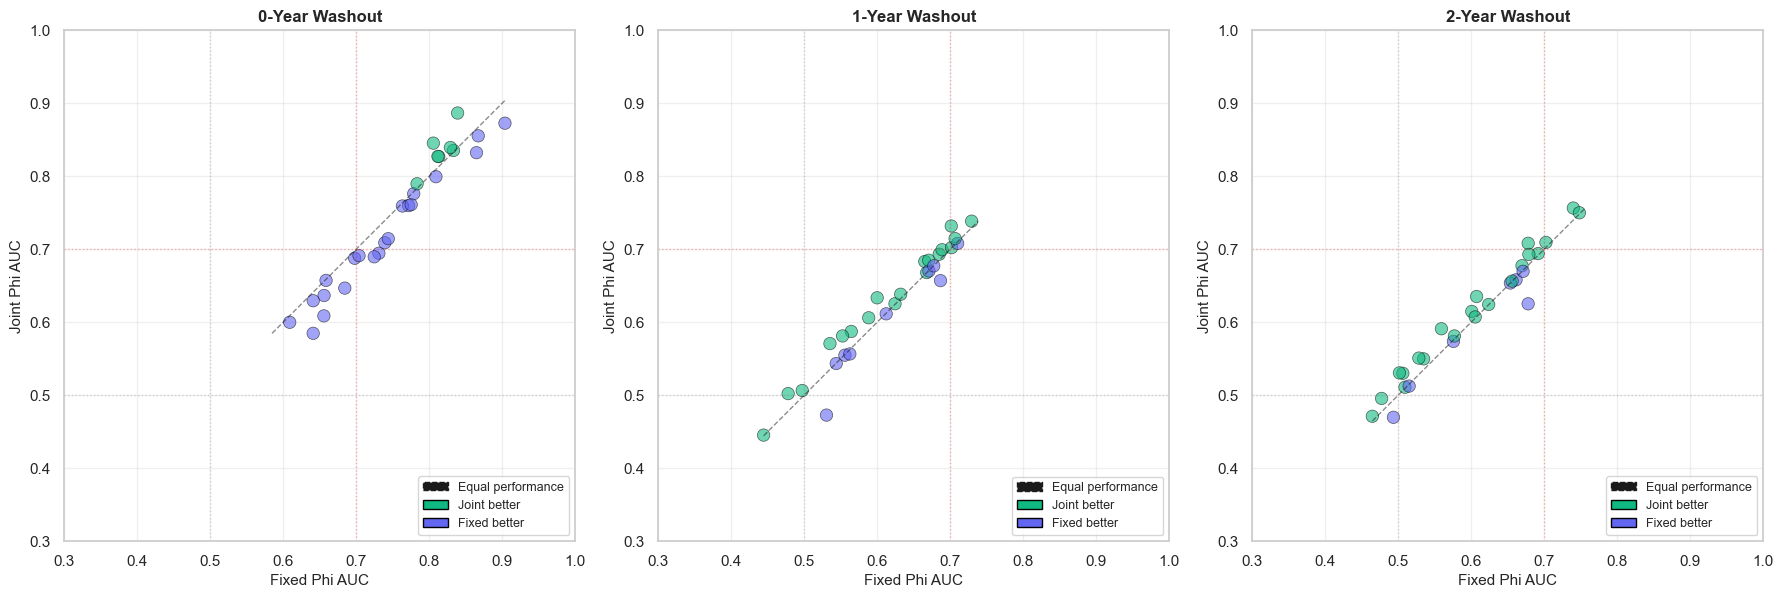


=== Summary: Joint vs Fixed Phi ===

0-Year Washout:
  Joint better: 7 diseases
  Fixed better: 21 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): -0.0115

1-Year Washout:
  Joint better: 19 diseases
  Fixed better: 9 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): 0.0064

2-Year Washout:
  Joint better: 21 diseases
  Fixed better: 7 diseases
  Ties: 0 diseases
  Mean difference (joint - fixed): 0.0067



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
fixed_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv")
joint_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table_jointest_1114.csv")

# Merge on Disease
comparison_df = fixed_df[["Disease"]].merge(
    fixed_df[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC"]].rename(
        columns={"0yr_AUC": "fixed_0yr", "1yr_AUC": "fixed_1yr", "2yr_AUC": "fixed_2yr"}
    ),
    on="Disease"
).merge(
    joint_df[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC"]].rename(
        columns={"0yr_AUC": "joint_0yr", "1yr_AUC": "joint_1yr", "2yr_AUC": "joint_2yr"}
    ),
    on="Disease"
)

# Calculate differences (positive = joint better, negative = fixed better)
for period in ["0yr", "1yr", "2yr"]:
    comparison_df[f"diff_{period}"] = comparison_df[f"joint_{period}"] - comparison_df[f"fixed_{period}"]

# Create three scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
periods = ["0yr", "1yr", "2yr"]
titles = ["0-Year Washout", "1-Year Washout", "2-Year Washout"]

for idx, (period, title) in enumerate(zip(periods, titles)):
    ax = axes[idx]
    
    fixed_aucs = comparison_df[f"fixed_{period}"].values
    joint_aucs = comparison_df[f"joint_{period}"].values
    
    # Remove NaN values for plotting
    mask = ~(pd.isna(fixed_aucs) | pd.isna(joint_aucs))
    fixed_clean = fixed_aucs[mask]
    joint_clean = joint_aucs[mask]
    
    # Color points based on which is better
    colors = ['#10b981' if j > f else '#6366f1' for f, j in zip(fixed_clean, joint_clean)]
    
    # Create scatter plot
    ax.scatter(fixed_clean, joint_clean, c=colors, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Add diagonal line (y=x) - where fixed = joint
    min_val = min(fixed_clean.min(), joint_clean.min())
    max_val = max(fixed_clean.max(), joint_clean.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, alpha=0.5)
    
    # Add reference lines
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.3)
    ax.axvline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.3)
    ax.axhline(0.7, color='red', linestyle=':', linewidth=1, alpha=0.3)
    ax.axvline(0.7, color='red', linestyle=':', linewidth=1, alpha=0.3)
    
    ax.set_xlabel('Fixed Phi AUC', fontsize=11)
    ax.set_ylabel('Joint Phi AUC', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0.3, 1.0)
    ax.set_ylim(0.3, 1.0)
    ax.set_aspect('equal')
    ax.grid(alpha=0.3)
    
    # Create custom legend with correct colors
    legend_elements = [
        Patch(facecolor='k', edgecolor='k', linestyle='--', label='Equal performance'),
        Patch(facecolor='#10b981', edgecolor='black', label='Joint better'),
        Patch(facecolor='#6366f1', edgecolor='black', label='Fixed better')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary: Joint vs Fixed Phi ===\n")
for period, title in zip(periods, titles):
    diff = comparison_df[f"diff_{period}"].dropna()
    joint_better = (diff > 0).sum()
    fixed_better = (diff < 0).sum()
    ties = (diff == 0).sum()
    mean_diff = diff.mean()
    
    print(f"{title}:")
    print(f"  Joint better: {joint_better} diseases")
    print(f"  Fixed better: {fixed_better} diseases")
    print(f"  Ties: {ties} diseases")
    print(f"  Mean difference (joint - fixed): {mean_diff:.4f}")
    print()